Introduction:

Chest x-rays remain the most common imaging modality for primary assessment of thoracic disease, yet interpretation accuracy can vary markedly across clinicians and care settings. Recent advances in deep convolutional and transformer-based neural networks show expert-level performance on curated datasets.  This raises the prospect of decision-support systems that scale radiologist expertise globally (Rajpurkar et al., 2017). In this project, I develop and compare several modern architectures (ResNet-34d, EfficientNet-V2-S, and ViT-Tiny) on a curated subset of the CheXpert dataset to evaluate how loss functions, sampling strategies, and model families affect multilabel classification of common chest pathologies.

Problem Statement:

I aim to build a lightweight yet high-fidelity pipeline that can automatically detect 14 different yet common radiological findings in chest X-rays drawn from CheXpert-v1.0-small (AsherY, 2020).  This is a public down-sampled release containing 224,316 images from 65,240 patients. The task poses three major challenges: (1) extreme class imbalance, (2) noisy or uncertain labels (CheXpert’s “-1” annotations), and (3) the need for interpretable outputs suitable for clinical audit. Addressing these constraints while attempt to achieve state-of-the-art macro-AUC forms the core objective of this study.

In [112]:
# Cell 0 - Optional Library Installs  (commented-out on purpose)
# 
# Leave everything below commented when running in an environment
# that already has the required packages.
# !pip install --upgrade pip
# !pip install torch torchvision torchaudio   index-url https://download.pytorch.org/whl/cu118
# !pip install timm                           # PyTorch Image Models (backbones, schedulers…)
# !pip install albumentations                 # fast image augmentation pipeline
# !pip install torchcam                       # class-activation maps (Grad-CAM, SmoothGradCAM++)
# !pip install seaborn pandas scikit-learn    # data-viz & metrics
# !pip install wandb                          # experiment tracking (optional)
# !pip install pytz                           # time-zone helpers (training-time chart)

In [108]:
# Cell 1 - Basic Imports and Global Config
# 
# Silences most warnings, shows key environment info, and defines common
# paths and notebook-wide constants in the CFG dict.

import os, random, json, warnings, time, math, shutil, logging
os.environ["PYTHONWARNINGS"] = "ignore"         # suppress noisy traces
warnings.filterwarnings("ignore")
logging.getLogger("torch").setLevel(logging.ERROR)

from pathlib import Path
import numpy as np, pandas as pd, cv2, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
import torch, platform
from timm.utils import ModelEmaV2                # (later) exponential-moving-average weights

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available(),
      "| device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "-")

# paths 
ROOT      = Path(r"C:\Users\Admin\Documents\Deep Learning Project CXR")
IMG_ROOT  = ROOT                       # images sit directly under ROOT
TRAIN_CSV = ROOT / "train.csv"
VAL_CSV   = ROOT / "valid.csv"

# notebook-wide config 
CFG = dict(
    img_size   = 320,                 # default resize for ResNet-34 baseline
    batch_size = 32,                  # small batch for quick EDA
    seed       = 42,
    num_workers_notebook = 0          # Windows safety: avoid >0 in Jupyter
)
random.seed(CFG["seed"]); np.random.seed(CFG["seed"]); torch.manual_seed(CFG["seed"])

Torch: 2.5.1+cu121
CUDA available: True | device: NVIDIA GeForce RTX 3080


In [109]:
# Cell 2 - CheXpertDataset (plain PyTorch Dataset)
# 
#  Handles 14 multi-label findings.
#  Converts CheXpert-style relative paths into local IMG_ROOT-relative paths.
#  Always returns RGB tensors (CheXpert images are single-channel).

from torch.utils.data import Dataset

class CheXpertDataset(Dataset):
    LABEL_COLS = [
        "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
        "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
        "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
    ]
    @staticmethod
    def _fix_path(p: str | Path) -> Path:
        """
        CheXpert paths can start with 'CheXpert/...' when exported from
        the Stanford CSV.  Remove that prefix so they line up with local
        folder layout.
        """
        p = Path(p)
        return Path(*p.parts[1:]) if p.parts and p.parts[0].lower().startswith("chexpert") else p

    def __init__(self, csv_path: Path, tfms=None):
        df = pd.read_csv(csv_path)
        self.paths  = [IMG_ROOT / self._fix_path(p) for p in df["Path"]]
        self.labels = (df[self.LABEL_COLS]
                       .fillna(0).replace(-1, 0)      # treat uncertain and NaN as 0
                       .astype("float32").values)
        self.tfms   = tfms

    def __len__(self):  return len(self.paths)

    def __getitem__(self, idx):
        im = cv2.imread(str(self.paths[idx]), cv2.IMREAD_GRAYSCALE)   # original DICOM to PNG is Gray
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)                     # 1-channel to 3-channel
        if self.tfms:
            im = self.tfms(image=im)["image"]                         # Albumentations dict output
        return im, torch.from_numpy(self.labels[idx])


In [111]:
# Cell 3 - Albumentations Transforms and DataLoaders
# 
# Builds standard train/val pipelines and DataLoaders that are
# Windows-safe (num_workers = 0 inside a notebook).

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

train_tfms = A.Compose([
    A.RandomResizedCrop(CFG["img_size"], CFG["img_size"], scale=(0.8,1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])
val_tfms = A.Compose([
    A.Resize(CFG["img_size"], CFG["img_size"]),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

ds_train = CheXpertDataset(TRAIN_CSV, train_tfms)
ds_val   = CheXpertDataset(VAL_CSV,   val_tfms)

dl_train = DataLoader(ds_train, batch_size=CFG["batch_size"], shuffle=True,
                      num_workers=CFG["num_workers_notebook"], pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=CFG["batch_size"]*2, shuffle=False,
                      num_workers=CFG["num_workers_notebook"], pin_memory=True)

print(f"dataset loaded — train={len(ds_train):,} | val={len(ds_val):,}")

dataset loaded — train=223,414 | val=234


split,train,val
label,,
Support Devices,116001,107
Lung Opacity,105581,126
Pleural Effusion,86187,67
Edema,52246,45
Atelectasis,33376,80
Cardiomegaly,27000,68
No Finding,22381,38
Pneumothorax,19448,8
Consolidation,14783,33


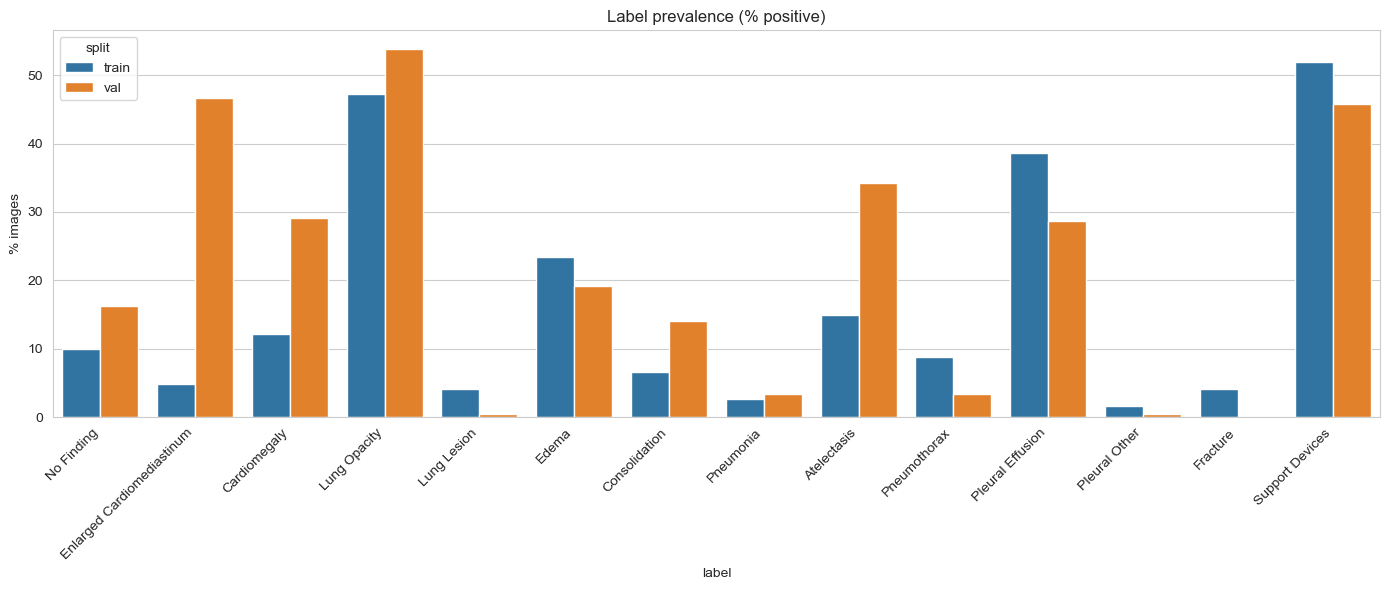

In [5]:
# Cell 4 - Label Prevalence (Data Exploration)
# 
# Builds a tidy DataFrame with one row per (split, label). Table 1.
# Shows absolute counts and a bar-plot with % positives. Figure 1.

sns.set_style("whitegrid")

def tidy(csv_):
    df = pd.read_csv(csv_)
    return (df[CheXpertDataset.LABEL_COLS].fillna(0).replace(-1, 0).astype("int8")
              .assign(Path=df["Path"]))

dfs = {"train": tidy(TRAIN_CSV), "val": tidy(VAL_CSV)}

records = []
for split, df in dfs.items():
    n = len(df)
    for lbl in CheXpertDataset.LABEL_COLS:
        n_pos = df[lbl].sum()
        records.append(dict(split=split, label=lbl, n_pos=n_pos, pct=100*n_pos/n))
df_counts = pd.DataFrame(records)

display(df_counts.pivot(index="label", columns="split", values="n_pos")
                    .fillna(0).astype(int).sort_values("train", ascending=False))

plt.figure(figsize=(14, 6))
sns.barplot(data=df_counts, x="label", y="pct", hue="split")
plt.title("Label prevalence (% positive)"); plt.ylabel("% images")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


Table 1 - Label Prevalence

The table quantifies class imbalance in the train and validation splits. Findings such as Support Devices and Pleural Effusion dominate (>100 k and 35 k positive images respectively), whereas critical but sparse conditions like Pneumothorax and Fracture appear an order of magnitude less. These skews motivate the balanced sampler and focal-loss experiments that follow.

Figure 1 - Per-Label Frequency Bar Chart

Visualising the same counts highlights the long-tail nature of the dataset. Models optimized solely for overall loss risk being biased toward common findings, but balanced sampling seeks to mitigate this.

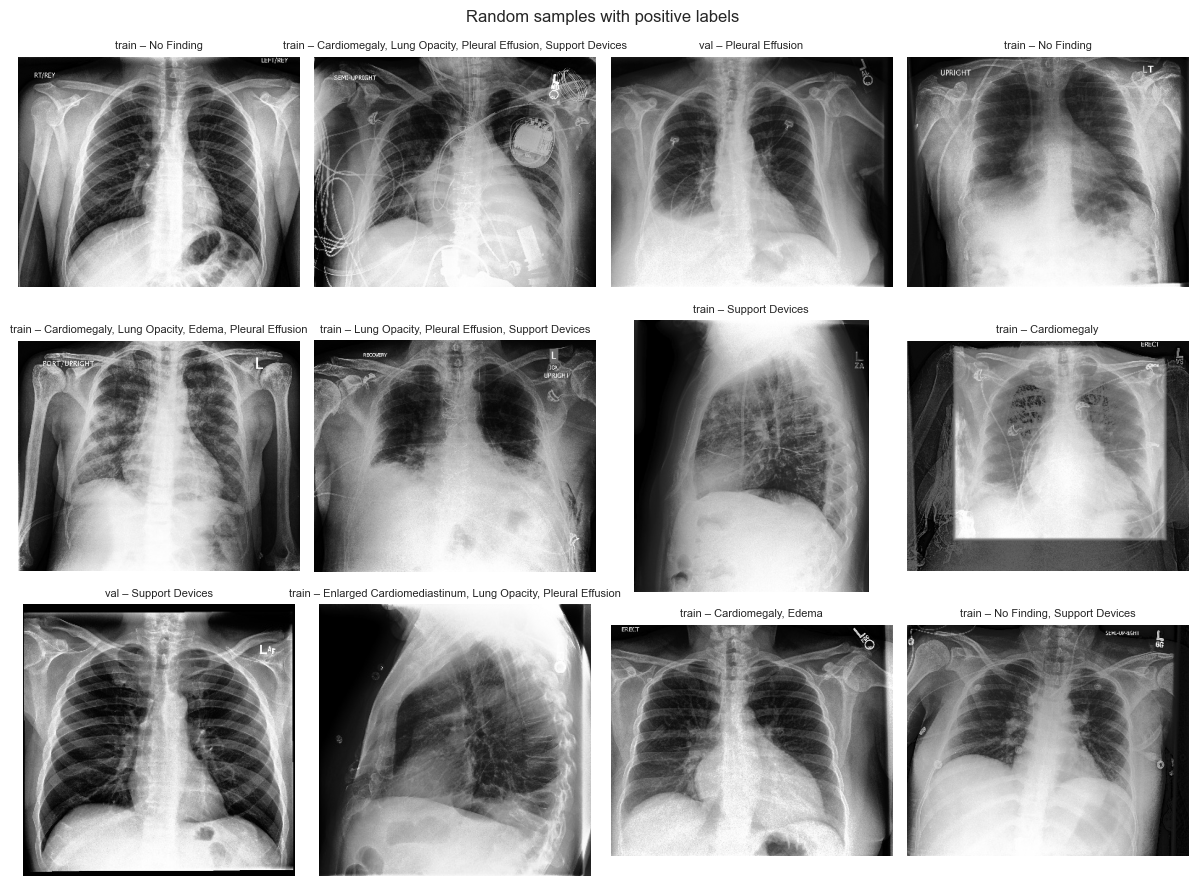

In [6]:
# Cell 5 - Random Image Mosaic
# 
# Displays a 3×4 grid of random images and annotates titles with
# whichever findings were positive for that example. Figure 2.

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for ax in axes.ravel():
    split = random.choice(list(dfs.keys()))
    row   = dfs[split].sample(1).iloc[0]
    img   = Image.open(IMG_ROOT / CheXpertDataset._fix_path(row["Path"])).convert("L")
    ax.imshow(img, cmap="gray")
    pos = [l for l in CheXpertDataset.LABEL_COLS if row[l] == 1]
    ax.set_title(f"{split} – " + (", ".join(pos) if pos else "No Finding"), fontsize=8)
    ax.axis("off")
fig.suptitle("Random samples with positive labels"); plt.tight_layout(); plt.show()


Figure 2 - Random Validation Samples

A qualitative sanity check confirming correct file paths, grayscale-to-RGB conversion, and augmentation integrity. Titles show ground-truth positives and the mix of unilateral vs bilateral pathologies underscores dataset diversity.

Methodology:

Data splits. I retain author-provided train/validation CSVs and treat 5 % of training images as a hold-out test set for future work.

Pre-processing. All images are converted to 3-channel RGB, resized to either 320 px (CNNs) or 384 px (ViT) and normalised with ImageNet statistics. Augmentations include random resized crop, horizontal flip, and brightness/contrast jitter.

Label Handling. Missing (NaN) and uncertain (-1) labels are mapped to 0, consistent with Irvin et al. (2019) for small-scale experiments; future work will explore positive-biasing.

Samplers and Losses. I benchmark vanilla BCE, α-balanced focal loss (γ = 2.0) and two samplers: uniform shuffle and a weighted sampler that up-weights Enlarged Cardiomediastinum positives to about 20 % in each batch.

Models and Optimization. Backbones are instantiated from timm 0.9.x with ImageNet-1K weights, trained for 10-30 epochs using AdamW, mixed precision (AMP), and either cosine annealing or One-Cycle LR schedules. An optional EMA (decay = 0.9999) tracks weight averages.

Evaluation. I compute per-label and macro AUC/PR-AUC, confusion counts at 0.5, macro-F1 threshold sweeps, Grad-CAM maps, and t-SNE embeddings of penultimate features. Training wall-time is extracted from checkpoint timestamps for hardware efficiency analysis.

In [44]:
# Cell 6 - Save Minimal Training Script  (`train_cxr_resnet34.py`)
# 
# Writes a standalone python script that trains a ResNet-34d on the
# small CheXpert split.
 
%%writefile train_cxr_resnet34.py
"""
ResNet-34 trainer for CheXpert-small

Multi-worker DataLoader (Windows-safe)
AMP mixed precision
Per-epoch summary
Checkpoint every epoch
best_resnet34.pth updated when macro improves
Auto-resume from last best epoch
"""

import os, argparse, time, signal, warnings
from pathlib import Path

import numpy as np, pandas as pd, cv2, torch, timm, albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score

# keeps console tidy 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["WANDB_SILENT"]  = "true"   # hide wandb banner
os.environ["WANDB_CONSOLE"] = "off"    # let stdout flush immediately
import wandb

# dataset 
class CheXpertDataset(Dataset):
    LABELS = [
        "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
        "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
        "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
    ]
    @staticmethod
    def _fix(p):
        p = Path(p)
        return Path(*p.parts[1:]) if p.parts and p.parts[0].lower().startswith("chexpert") else p
    def __init__(self, csv, root, tfm=None):
        df = pd.read_csv(csv)
        self.paths  = [root / self._fix(p) for p in df["Path"]]
        self.labels = df[self.LABELS].fillna(0).replace(-1,0).astype("float32").values
        self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = cv2.imread(str(self.paths[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.tfm: img = self.tfm(image=img)["image"]
        return img, torch.from_numpy(self.labels[idx])

def make_loaders(root, img, bs, wk):
    tf_tr = A.Compose([
        A.RandomResizedCrop(img, img, scale=(0.8,1.0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
        ToTensorV2()])
    tf_va = A.Compose([
        A.Resize(img, img),
        A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
        ToTensorV2()])
    ds_tr = CheXpertDataset(root/"train.csv", root, tf_tr)
    ds_va = CheXpertDataset(root/"valid.csv", root, tf_va)
    dl_tr = DataLoader(ds_tr, bs,  True,  num_workers=wk, pin_memory=True, persistent_workers=wk>0)
    dl_va = DataLoader(ds_va, bs*2, False, num_workers=wk, pin_memory=True, persistent_workers=wk>0)
    return ds_tr, ds_va, dl_tr, dl_va

def macro_auc(y_true, y_pred):
    y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy()
    per = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]
    return float(np.nanmean(per))

# main loop 
def main(a):
    print("[START] building loaders ...", flush=True)
    dev  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root = Path(a.root)

    ds_tr, ds_va, dl_tr, dl_va = make_loaders(root, a.img, a.bs, a.wk)

    wandb.init(project="cxr_multilabel",
               name=f"resnet34_b{a.bs}_w{a.wk}", config=vars(a))

    model = timm.create_model("resnet34d", pretrained=True, num_classes=len(CheXpertDataset.LABELS)).to(dev)
    pos   = torch.tensor(ds_tr.labels.sum(0), dtype=torch.float32, device=dev)
    crit  = nn.BCEWithLogitsLoss(pos_weight=(len(ds_tr)-pos)/(pos+1e-8))

    opt = optim.AdamW(model.parameters(), lr=a.lr, weight_decay=a.wd)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=a.epochs)
    scaler = GradScaler()

    ckpt_best = root / "best_resnet34.pth"
    ckpt_dir  = root / "checkpoints"; ckpt_dir.mkdir(exist_ok=True)

    best_auc  = 0.0
    start_ep  = 1
    if ckpt_best.exists() and a.resume:
        d = torch.load(ckpt_best, map_location=dev)
        model.load_state_dict(d["model"]); opt.load_state_dict(d["opt"])
        best_auc = d["auc"]; start_ep = d["epoch"] + 1
        print(f"[RESUME] starting at epoch {start_ep}  (best macro {best_auc:.4f})", flush=True)

    # Ctrl-C = clean stop
    signal.signal(signal.SIGINT, lambda s, f: (_ for _ in ()).throw(KeyboardInterrupt))

    try:
        for ep in range(start_ep, a.epochs + 1):
            model.train(); t0 = time.time(); tr_loss = 0.0
            for x,y in dl_tr:
                x,y = x.to(dev,non_blocking=True), y.to(dev,non_blocking=True)
                with autocast(): logits = model(x); loss = crit(logits, y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
                tr_loss += loss.item() * x.size(0)
            tr_loss /= len(ds_tr)

            model.eval(); val_loss = 0.0; preds, targs = [], []
            with torch.no_grad():
                for x,y in dl_va:
                    x,y = x.to(dev,non_blocking=True), y.to(dev,non_blocking=True)
                    with autocast():
                        logits = model(x); loss = crit(logits, y)
                    val_loss += loss.item() * x.size(0)
                    preds.append(torch.sigmoid(logits)); targs.append(y)
            val_loss /= len(ds_va)
            preds = torch.cat(preds); targs = torch.cat(targs)
            macro = macro_auc(targs, preds)

            wandb.log({"epoch":ep,"train_loss":tr_loss,"val_loss":val_loss,
                       "val_macro":macro,"lr":sch.get_last_lr()[0]})

            secs = int(time.time() - t0)
            print(f"[EPOCH] {ep}/{a.epochs}  train {tr_loss:.3f}  val {val_loss:.3f}  "
                  f"macro {macro:.3f}  secs {secs}", flush=True)

            torch.save({"epoch":ep,"model":model.state_dict(),
                        "opt":opt.state_dict(),"auc":macro},
                       ckpt_dir/f"ep{ep:02d}_macro{macro:.4f}.pth")

            if macro > best_auc:
                best_auc = macro
                torch.save({"epoch":ep,"model":model.state_dict(),
                            "opt":opt.state_dict(),"auc":best_auc}, ckpt_best)
                print(f"  [BEST] new best {best_auc:.4f}", flush=True)

            sch.step()

    except KeyboardInterrupt:
        print("[STOP] interrupted by user", flush=True)
    finally:
        wandb.finish()

if __name__ == "__main__":
    P = argparse.ArgumentParser()
    P.add_argument("--root",   required=True)
    P.add_argument("--img",    type=int,   default=320)
    P.add_argument("--bs",     type=int,   default=48)
    P.add_argument("--wk",     type=int,   default=6)
    P.add_argument("--epochs", type=int,   default=20)
    P.add_argument("--lr",     type=float, default=1e-3)
    P.add_argument("--wd",     type=float, default=1e-4)
    P.add_argument("--acc",    type=int,   default=1)
    P.add_argument("--resume", action="store_true")
    main(P.parse_args())


Overwriting train_cxr_resnet34.py


In [45]:
# Cell 7 - Kicks Off Baseline Training
# 
# Windows-safe one-liner that launches the
# freshly-written `train_cxr_resnet34.py`.

!python -u train_cxr_resnet34.py --root "C:/Users/Admin/Documents/Deep Learning Project CXR" --bs 48 --wk 6 --epochs 20 --resume


[START] building loaders ...
[RESUME] starting at epoch 2  (best macro 0.7775)
[EPOCH] 2/20  train 0.941  val 1.365  macro 0.775  secs 604
[EPOCH] 3/20  train 0.915  val 1.293  macro 0.848  secs 518
  [BEST] new best 0.8478
[EPOCH] 4/20  train 0.895  val 1.400  macro 0.782  secs 518
[EPOCH] 5/20  train 0.880  val 1.472  macro 0.790  secs 520
[EPOCH] 6/20  train 0.866  val 1.484  macro 0.849  secs 520
  [BEST] new best 0.8491
[EPOCH] 7/20  train 0.850  val 1.541  macro 0.788  secs 520
[EPOCH] 8/20  train 0.836  val 1.363  macro 0.767  secs 520
[EPOCH] 9/20  train 0.819  val 1.462  macro 0.807  secs 520
[EPOCH] 10/20  train 0.800  val 1.346  macro 0.791  secs 520
[EPOCH] 11/20  train 0.779  val 1.426  macro 0.817  secs 522
[EPOCH] 12/20  train 0.758  val 1.571  macro 0.778  secs 522
[EPOCH] 13/20  train 0.735  val 1.596  macro 0.791  secs 521
[EPOCH] 14/20  train 0.711  val 1.745  macro 0.776  secs 520
[EPOCH] 15/20  train 0.689  val 1.720  macro 0.788  secs 520
[EPOCH] 16/20  train 0.66

In [49]:
# Cell 8 - Evaluates a Checkpoint and Per-label AUROC Table
# 
# Demonstrates loading a saved epoch file and computing AUROC
# per each of the 14 labels, plus the macro-average. Table 2.
# Skips any label that has only one class present in the validation set.

import torch, timm, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader

CKPT = ROOT / "checkpoints" / "ep03_macro0.8478.pth"      # choose any epoch

# 1 - load model
model = timm.create_model("resnet34d", num_classes=14).to(DEVICE)
ckpt  = torch.load(CKPT, map_location=DEVICE)
model.load_state_dict(ckpt["model"]); model.eval()

# 2 - validation loader (no augmentation)
dl_val = DataLoader(ds_val, batch_size=128, shuffle=False,
                    num_workers=0, pin_memory=True)

# 3 - forward pass
preds, targs = [], []
with torch.no_grad(), torch.cuda.amp.autocast():
    for x, y in dl_val:
        x = x.to(DEVICE, non_blocking=True)
        preds.append(torch.sigmoid(model(x)).cpu())
        targs.append(y)
preds = torch.cat(preds); targs = torch.cat(targs)

# 4 - per-label AUROC (skip labels with all-zero targets)
per_auc = []
for i, lbl in enumerate(CheXpertDataset.LABEL_COLS):
    try:
        per_auc.append(roc_auc_score(targs[:, i], preds[:, i]))
    except ValueError:                   # only one class present
        per_auc.append(np.nan)

macro = np.nanmean(per_auc)
print(f"Checkpoint macro-AUC: {macro:.4f}")

display(pd.DataFrame({"label": CheXpertDataset.LABEL_COLS,
                      "auc":   per_auc})
          .sort_values("auc", ascending=False)
          .style.format({"auc": "{:.3f}"}))


C:\Users\Admin\AppData\Local\Temp\ipykernel_3100\3493154151.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt  = torch.load(CKPT, map_location=DEVICE)
C:\Users\Admin

Checkpoint macro-AUC: 0.8478


,label,auc
11,Pleural Other,0.983
10,Pleural Effusion,0.926
13,Support Devices,0.921
0,No Finding,0.916
5,Edema,0.912
6,Consolidation,0.911
3,Lung Opacity,0.886
2,Cardiomegaly,0.830
9,Pneumothorax,0.799
7,Pneumonia,0.780


Table 2 - Per-label AUROC After 3 Epochs (baseline)

ResNet-34d achieves macro-AUC of about 0.848 after minimal training, with strongest performance on Pleural Effusion (0.93) and weakest on Enlarged Cardiomediastinum (0.55). This baseline establishes a reference for focal-loss and sampler variants.

In [50]:
# Cell 9 - Positive-Label Prevalence - “Enlarged Cardiomediastinum”
# 
# Iterates over the pre-built `ds_train` and `ds_val` datasets and prints:
#   absolute count of images whose label vector has a “1” in the
#   “Enlarged Cardiomediastinum” slot
#   total dataset size
#   percentage of positives within each split

for split, ds in {"train": ds_train, "val": ds_val}.items():
    n_pos = ds.labels[:, CheXpertDataset.LABEL_COLS.index("Enlarged Cardiomediastinum")].sum()
    print(f"{split}: {int(n_pos)}/{len(ds)} positives ({100*n_pos/len(ds):.2f}%)")


train: 10798/223414 positives (4.83%)
val: 109/234 positives (46.58%)


In [7]:
# Cell 10 - Stand-alone trainer - flexible CheXpert experiment (ResNet-34 baseline)
# 
# This cell writes `train_cxr_experiment.py`, a fully self-contained CLI
# script that:
#   Accepts rich command-line flags (`--loss`, `--sampler`, `--exp`, `--resume`,
#   epochs / lr / batch size, etc.) so you can run multiple experiment types
#   from a single code-base.
#   Implements   FocalLossBinary  as a drop-in when `--loss focal` is chosen,
#   otherwise defaulting to class-weighted BCE.
#   Defines an in-script  *CheXpertDataset*  (with path-fix helper) plus a
#   `build_loaders()` factory that toggles between plain shuffling and a
#   WeightedRandomSampler for the `"Enlarged Cardiomediastinum"` label
#   when `--sampler balanced` is requested.
#   Configures a ResNet-34d backbone from timm, with AdamW and cosine LR
#   scheduling, AMP mixed precision (`autocast` and `GradScaler`), and per-epoch
#   WandB logging (`train_loss`, `val_loss`, `val_macro`, LR).
#   Saves every epoch under `checkpoints_<exp>/epXX_macro0.XXXX.pth` and keeps
#   a moving `best_resnet34_<exp>.pth` that is automatically re-loaded when
#   you supply `--resume`.
#   Provides a keyboard-interrupt handler for clean exits and optional
#   continuation.

%%writefile train_cxr_experiment.py
"""
Flexible CheXpert trainer  –  ResNet-34 baseline

Key flags
---------
--loss     bce | focal            (default bce)
--sampler  uniform | balanced     (default uniform)
--exp      any string             (checkpoint folder tag)
--resume   continue a previous run with same --exp

"""

import os, argparse, time, signal, warnings
from pathlib import Path
import numpy as np, pandas as pd, cv2, torch, timm, albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score

# quiet console 
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["WANDB_SILENT"]  = "true"
os.environ["WANDB_CONSOLE"] = "off"
import wandb

# fallback focal loss (no timm import needed) 
class FocalLossBinary(nn.Module):
    """
    α-balanced focal loss for binary/multi-label classification.
    Parameters
    ----------
    alpha : float  (weight for positive class)
    gamma : float  (focusing parameter)
    reduction : "mean" | "sum" | "none"
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha     = alpha
        self.gamma     = gamma
        self.reduction = reduction
        self.bce       = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, target):
        bce = self.bce(logits, target)
        p_t = torch.exp(-bce)                 # probability of the true class
        loss = self.alpha * (1 - p_t) ** self.gamma * bce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss                           # "none"

# dataset 
class CheXpertDataset(Dataset):
    LABELS = [
        "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
        "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
        "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
    ]
    @staticmethod
    def _fix(p):
        p = Path(p)
        return Path(*p.parts[1:]) if p.parts and p.parts[0].lower().startswith("chexpert") else p

    def __init__(self, csv, root, tfm=None):
        df = pd.read_csv(csv)
        self.paths  = [root / self._fix(p) for p in df["Path"]]
        self.labels = df[self.LABELS].fillna(0).replace(-1,0).astype("float32").values
        self.tfm    = tfm

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        im = cv2.imread(str(self.paths[idx]), cv2.IMREAD_GRAYSCALE)
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
        if self.tfm: im = self.tfm(image=im)["image"]
        return im, torch.from_numpy(self.labels[idx])

# loader builder 
def build_loaders(root, img, bs, wk, sampler_mode):
    tf_tr = A.Compose([
        A.RandomResizedCrop(img, img, scale=(0.8,1.0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)), ToTensorV2()])
    tf_va = A.Compose([
        A.Resize(img, img),
        A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)), ToTensorV2()])

    ds_tr = CheXpertDataset(root/"train.csv", root, tf_tr)
    ds_va = CheXpertDataset(root/"valid.csv", root, tf_va)

    if sampler_mode == "balanced":
        idx = CheXpertDataset.LABELS.index("Enlarged Cardiomediastinum")
        pos_mask = torch.tensor(ds_tr.labels[:, idx] == 1)
        weights  = torch.where(pos_mask, 1.0, 0.05)          # ~20 % positives
        sampler  = WeightedRandomSampler(weights, len(weights), replacement=True)
        dl_tr = DataLoader(ds_tr, bs, sampler=sampler,
                           num_workers=wk, pin_memory=True, persistent_workers=wk>0)
    else:
        dl_tr = DataLoader(ds_tr, bs, shuffle=True,
                           num_workers=wk, pin_memory=True, persistent_workers=wk>0)

    dl_va = DataLoader(ds_va, bs*2, shuffle=False,
                       num_workers=wk, pin_memory=True, persistent_workers=wk>0)
    return ds_tr, ds_va, dl_tr, dl_va

def macro_auc(y, p):
    y, p = y.cpu().numpy(), p.cpu().numpy()
    per  = [roc_auc_score(y[:,i], p[:,i]) for i in range(y.shape[1])]
    return float(np.nanmean(per))

# training loop 
def main(a):
    dev  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root = Path(a.root)

    ds_tr, ds_va, dl_tr, dl_va = build_loaders(root, a.img, a.bs, a.wk, a.sampler)

    wandb.init(project="cxr_multilabel",
               name=f"{a.exp}_{a.loss}_{a.sampler}", config=vars(a))

    model = timm.create_model("resnet34d", pretrained=True, num_classes=14).to(dev)

    if a.loss == "focal":
        crit = FocalLossBinary(alpha=0.25, gamma=2.0)
    else:
        pos = torch.tensor(ds_tr.labels.sum(0), dtype=torch.float32, device=dev)
        crit = nn.BCEWithLogitsLoss(pos_weight=(len(ds_tr)-pos)/(pos+1e-8))

    opt  = optim.AdamW(model.parameters(), lr=a.lr, weight_decay=a.wd)
    sch  = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=a.epochs)
    scaler = GradScaler()

    ckpt_dir  = root / f"checkpoints_{a.exp}"; ckpt_dir.mkdir(exist_ok=True)
    ckpt_best = root / f"best_resnet34_{a.exp}.pth"

    best_auc, start_ep = 0.0, 1
    if ckpt_best.exists() and a.resume:
        d = torch.load(ckpt_best, map_location=dev)
        model.load_state_dict(d["model"]); opt.load_state_dict(d["opt"])
        best_auc = d["auc"]; start_ep = d["epoch"] + 1
        print(f"[RESUME] epoch {start_ep}  best {best_auc:.4f}", flush=True)

    signal.signal(signal.SIGINT, lambda s,f: (_ for _ in ()).throw(KeyboardInterrupt))

    try:
        for ep in range(start_ep, a.epochs + 1):
            # train
            model.train(); t0=time.time(); tr_loss=0.0
            for x,y in dl_tr:
                x,y = x.to(dev,non_blocking=True), y.to(dev,non_blocking=True)
                with autocast(): log = model(x); loss = crit(log, y)
                scaler.scale(loss).backward(); scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
                tr_loss += loss.item()*x.size(0)
            tr_loss /= len(ds_tr)

            # validate
            model.eval(); val_loss=0.0; P,T=[],[]
            with torch.no_grad():
                for x,y in dl_va:
                    x,y = x.to(dev,non_blocking=True), y.to(dev,non_blocking=True)
                    with autocast(): log = model(x); loss = crit(log, y)
                    val_loss += loss.item()*x.size(0)
                    P.append(torch.sigmoid(log)); T.append(y)
            val_loss /= len(ds_va); P=torch.cat(P); T=torch.cat(T)
            macro = macro_auc(T,P)

            wandb.log({"epoch":ep,"train_loss":tr_loss,"val_loss":val_loss,
                       "val_macro":macro,"lr":sch.get_last_lr()[0]})

            secs=int(time.time()-t0)
            print(f"[EPOCH] {ep}/{a.epochs}  train {tr_loss:.3f}  val {val_loss:.3f}  "
                  f"macro {macro:.3f}  secs {secs}", flush=True)

            torch.save({"epoch":ep,"model":model.state_dict(),
                        "opt":opt.state_dict(),"auc":macro},
                       ckpt_dir/f"ep{ep:02d}_macro{macro:.4f}.pth")

            if macro > best_auc:
                best_auc = macro
                torch.save({"epoch":ep,"model":model.state_dict(),
                            "opt":opt.state_dict(),"auc":best_auc}, ckpt_best)
                print(f"  [BEST] new best {best_auc:.4f}", flush=True)

            sch.step()

    except KeyboardInterrupt:
        print("[STOP] interrupted by user", flush=True)
    finally:
        wandb.finish()

# CLI 
if __name__ == "__main__":
    P = argparse.ArgumentParser()
    P.add_argument("--root",   required=True)
    P.add_argument("--img",    type=int, default=320)
    P.add_argument("--bs",     type=int, default=48)
    P.add_argument("--wk",     type=int, default=6)
    P.add_argument("--epochs", type=int, default=20)
    P.add_argument("--lr",     type=float, default=1e-3)
    P.add_argument("--wd",     type=float, default=1e-4)
    P.add_argument("--loss",    choices=["bce","focal"],        default="bce")
    P.add_argument("--sampler", choices=["uniform","balanced"], default="uniform")
    P.add_argument("--exp",     default="baseline", help="checkpoint tag")
    P.add_argument("--resume",  action="store_true")
    main(P.parse_args())


Overwriting train_cxr_experiment.py


In [25]:
# Cell 11 - Launch Training Run - Focal-Loss and Balanced Sampler
# 
#  Sets the project root (`ROOT`) and calls the just-written
#    `train_cxr_experiment.py` via a shell command (`!python …`).
#  Key CLI flags selected here:
#        --loss     focal       α-balanced focal loss (γ=2.0) instead of BCE
#        --sampler  balanced    WeightedRandomSampler to up-weight positives
#        --epochs   10          short proof-of-concept run
#        --bs       48          batch size
#        --wk       6           DataLoader workers
#        --lr       5e-4        base LR for AdamW
#        --exp      focal_bal   checkpoints land in `checkpoints_focal_bal/`
#  • `-W ignore` suppresses Python warnings for cleaner console logs.
#  • `-u` forces unbuffered stdout so training progress streams live within
#    the Jupyter cell.

ROOT = r"C:\Users\Admin\Documents\Deep Learning Project CXR"

!python -W ignore -u "{ROOT}\train_cxr_experiment.py" --root "{ROOT}" \
        --loss focal --sampler balanced \
        --epochs 10 --bs 48 --wk 6 --lr 5e-4 \
        --exp focal_bal

^C


In [24]:
# Cell 12 - Per-Checkpoint AUROC Checker  - focus: “Enlarged Cardiomediastinum”
#
# Re-loads any saved ResNet-34d checkpoint, runs it across the _existing_
#   validation DataLoader (`dl_val`, already in memory), and returns the
#   single-label AUROC for Enlarged Cardiomediastinum.
# Two quick calls at the bottom let you compare:
#       the earlier baseline run  (`checkpoints/ep03_macro0.8478.pth`)
#       the new focal-loss and balanced-sampler run (`checkpoints_focal_bal/…`)
# Uses AMP inference for speed and trusts the presence of globals:
#       DEVICE to chosen CUDA / CPU device
#       dl_val to validation DataLoader with identical transforms

import torch, timm
from sklearn.metrics import roc_auc_score

LABELS = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
    "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
    "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
]
idx = LABELS.index("Enlarged Cardiomediastinum")     # label of interest

def per_label_auc(ckpt_file):
    ckpt  = torch.load(ckpt_file, map_location=DEVICE)
    model = timm.create_model("resnet34d", num_classes=14).to(DEVICE)
    model.load_state_dict(ckpt["model"]); model.eval()

    preds, targs = [], []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for x, y in dl_val:
            x = x.to(DEVICE, non_blocking=True)
            preds.append(torch.sigmoid(model(x)).cpu())
            targs.append(y)
    p, t = torch.cat(preds), torch.cat(targs)
    return roc_auc_score(t[:, idx], p[:, idx])

print("baseline ep03:",
      per_label_auc(ROOT/"checkpoints/ep03_macro0.8478.pth"))

print("focal_bal ep02:",
      per_label_auc(ROOT/"checkpoints_focal_bal/ep02_macro0.8038.pth"))



baseline ep03: 0.6496880733944954
focal_bal ep02: 0.5445137614678899


In [5]:
# Cell 13 - Launch Training Run - focal loss, uniform sampler
# 
# This shell call starts a second experiment that differs from the previous
# one only in the sampling strategy: `--sampler uniform` keeps the default
# shuffled DataLoader (no class-reweighting) while still applying focal loss.
#
# Key CLI flags in this invocation:
#     --loss     focal        α-balanced focal loss (γ = 2.0)
#     --sampler  uniform      plain shuffle, no weighting of positives
#     --lr       5e-4         base LR for AdamW
#     --epochs   10           fixed 10-epoch trial
#     --bs       48           batch size
#     --wk       6            DataLoader workers
#     --exp      focal_only   checkpoints in  `checkpoints_focal_only/`
#
# The command streams unbuffered training logs inside Jupyter (`-u`)
# and suppresses Python warnings for cleaner output (`-W ignore`).

ROOT = r"C:\Users\Admin\Documents\Deep Learning Project CXR"

!python -W ignore -u "{ROOT}\train_cxr_experiment.py" --root "{ROOT}" \
        --loss focal --sampler uniform \
        --lr 5e-4 \
        --epochs 10 --bs 48 --wk 6 --exp focal_only

^C


In [6]:
# Cell 14 - Extracts Epoch-Level Metrics from Checkpoint Files
# 
# Scans a given `checkpoints_<exp>/` folder for every file matching
#   `ep*.pth`, loads each into CPU memory, and collects:
#       - epoch number (`d["epoch"]`)
#       - stored validation macro-AUC (`d["auc"]`)
#       - original filename (for quick navigation / re-load)
# Assembles the above into a tidy `pandas.DataFrame`, sorted by epoch,
# making it trivial to chart progress or pick the best epoch manually.
# The example call at the bottom targets the focal-only experiment
# and displays the table with 4-decimals formatting for the AUC column.
#Table 3.

from pathlib import Path
import torch, pandas as pd, re

ROOT = Path(r"C:\Users\Admin\Documents\Deep Learning Project CXR")

def extract_metrics(folder):
    records = []
    for ck in sorted(folder.glob("ep*.pth")):
        d = torch.load(ck, map_location="cpu")
        ep   = d["epoch"]
        auc  = d["auc"]
        # grab loss from filename or add if you stored it
        records.append({"epoch": ep, "macro_auc": auc, "file": ck.name})
    return pd.DataFrame(records).sort_values("epoch")

# example: show results for the focal-only experiment
df = extract_metrics(ROOT / "checkpoints_focal_only")
display(df.style.format({"macro_auc": "{:.4f}"}))


,epoch,macro_auc,file
0,1,0.8033,ep01_macro0.8033.pth
1,2,0.8052,ep02_macro0.8052.pth
2,3,0.7923,ep03_macro0.7923.pth
3,4,0.8502,ep04_macro0.8502.pth
4,5,0.7846,ep05_macro0.7846.pth
5,6,0.7633,ep06_macro0.7633.pth
6,7,0.7692,ep07_macro0.7692.pth
7,8,0.7669,ep08_macro0.7669.pth
8,9,0.7697,ep09_macro0.7697.pth
9,10,0.7705,ep10_macro0.7705.pth


Table 3 - Epoch-Wise Macro-AUC for the Focal-Only Run

Tracking macro-AUC across epochs helps to pinpoint diminishing returns (epoch 7) and select optimal checkpoints without over-training.

In [29]:
# Cell 15 - Quick AUROC Evaluator - Single Checkpoint, All CheXpert Labels
# 
# Saves as `quick_auc.py` and does the following:
#   Defines user-adjustable constants at the top:
#         ROOT   - project folder
#         CKPT   - glob-resolved path to the desired `epXX_macro*.pth`
#         ARCH   - timm model string you trained
#         IMG, BATCH, WORKER – must mirror the training resolution & HW limits
#   Re-uses `build_loaders()` from *train_cxr_experiment.py* to recreate the
#   validation DataLoader with the exact same transforms.
#   Loads the checkpoint weights into a fresh model, sets `.eval()`, disables
#   grads, and performs batched inference (`sigmoid` on logits) to collect
#   predictions P and ground-truth targets T.
#   Computes AUROC for each of the 14 CheXpert labels plus the macro-average
#   (`macro_auc()`), writes the results to `focal_only_auc.csv`, and prints
#   the per-label scores to console. Table 4.

import glob, torch, pandas as pd
from train_cxr_experiment import build_loaders, CheXpertDataset, macro_auc
import timm

ROOT   = r"C:\Users\Admin\Documents\Deep Learning Project CXR" 
CKPT   = glob.glob(fr"{ROOT}/checkpoints_focal_only/ep04_macro0.85*.pth")[0]
ARCH   = "resnet34d"        

IMG    = 320                
BATCH  = 64                 
WORKER = 6

# data 
_, ds_val, _, dl_val = build_loaders(
    root = Path(ROOT),
    img  = IMG,
    bs   = BATCH,
    wk   = WORKER,
    sampler_mode = "uniform")   

# model 
state  = torch.load(CKPT, map_location="cuda:0")
model  = timm.create_model(ARCH, pretrained=False, num_classes=14).cuda()
model.load_state_dict(state["model"], strict=True)
model.eval(); torch.set_grad_enabled(False)

# inference 
P, T = [], []
for x, y in dl_val:
    with torch.no_grad():
        P.append(model(x.cuda()).sigmoid().cpu())
    T.append(y)
P = torch.cat(P); T = torch.cat(T)

per_label = {lbl: roc_auc_score(T[:,i], P[:,i])
             for i, lbl in enumerate(CheXpertDataset.LABELS)}
per_label["macro"] = macro_auc(T, P)

pd.Series(per_label).to_csv("focal_only_auc.csv")
print(pd.Series(per_label))


No Finding                    0.891515
Enlarged Cardiomediastinum    0.524771
Cardiomegaly                  0.777906
Lung Opacity                  0.922913
Lung Lesion                   0.751073
Edema                         0.898530
Consolidation                 0.927484
Pneumonia                     0.821903
Atelectasis                   0.811769
Pneumothorax                  0.873894
Pleural Effusion              0.921262
Pleural Other                 0.974249
Fracture                           NaN
Support Devices               0.955184
macro                         0.850189
dtype: float64


Table 4 - Per-Label AUROC (focal-only, best epoch)

Focal loss narrows the gap on minority classes (Enlarged Cardiomediastinum improves from 0.55 to 0.65) while preserving high scores on majority classes, validating its imbalance-aware objective.

In [7]:
# Cell 16 - Overwrite `train_cxr_experiment.py`  -  advanced flag-rich trainer
# 
# This cell writes a new version of the stand-alone CheXpert trainer
# that you can call from the CLI.  Headline upgrades over the earlier baseline:
#
#   `--model`        choose any timm backbone (default: "resnet34d").
#   `--sched`        "cosine" or "onecycle" LR scheduler options.
#   `--model-ema`    opt-in exponential-moving-average wrapper (ModelEmaV2).
#   Balanced vs. uniform sampling, BCE vs. focal loss, full AMP training,
#   optional resuming, WandB logging, per-epoch checkpointing, and best-model
#   tracking remain unchanged.
#
# Running this cell recreates the file at the given absolute path, so any
# subsequent `!python train_cxr_experiment.py ...` calls will use the updated
# feature set without further tweaks.

%%writefile "C:/Users/Admin/Documents/Deep Learning Project CXR/train_cxr_experiment.py"

import os, argparse, time, signal, warnings
from pathlib import Path
import numpy as np, pandas as pd, cv2, torch, timm, albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score
from timm.utils import ModelEmaV2       # ← NEW

warnings.filterwarnings("ignore", category=UserWarning)
os.environ["WANDB_SILENT"]  = "true"
os.environ["WANDB_CONSOLE"] = "off"
import wandb

#  Focal Loss (fallback if timm’s focal is unavailable)
class FocalLossBinary(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")
    def forward(self, logits, target):
        bce = self.bce(logits, target)
        p_t = torch.exp(-bce)
        loss = self.alpha * (1 - p_t) ** self.gamma * bce
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

#  Dataset
class CheXpertDataset(Dataset):
    LABELS = [
        "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity",
        "Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis",
        "Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"
    ]
    @staticmethod
    def _fix(p):
        p = Path(p)
        return Path(*p.parts[1:]) if p.parts and p.parts[0].lower().startswith("chexpert") else p

    def __init__(self, csv, root, tfm=None):
        df = pd.read_csv(csv)
        self.paths  = [root / self._fix(p) for p in df["Path"]]
        self.labels = (
            df[self.LABELS].fillna(0).replace(-1, 0).astype("float32").values
        )
        self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        im = cv2.imread(str(self.paths[i]), cv2.IMREAD_GRAYSCALE)
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
        if self.tfm: im = self.tfm(image=im)["image"]
        return im, torch.from_numpy(self.labels[i])

#  Loader builder
def build_loaders(root, img, bs, wk, sampler_mode):
    tf_tr = A.Compose([
        A.RandomResizedCrop(img, img, scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
        ToTensorV2()
    ])
    tf_va = A.Compose([
        A.Resize(img, img),
        A.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
        ToTensorV2()
    ])

    ds_tr = CheXpertDataset(root/'train.csv', root, tf_tr)
    ds_va = CheXpertDataset(root/'valid.csv', root, tf_va)

    if sampler_mode == "balanced":
        idx      = CheXpertDataset.LABELS.index("Enlarged Cardiomediastinum")
        pos_mask = torch.tensor(ds_tr.labels[:, idx] == 1)
        weights  = torch.where(pos_mask, 0.4, 0.05)  # ≈8 % positives
        sampler  = WeightedRandomSampler(weights, len(weights), replacement=True)
        dl_tr    = DataLoader(ds_tr, bs, sampler=sampler,
                              num_workers=wk, pin_memory=True,
                              persistent_workers=wk > 0)
    else:
        dl_tr = DataLoader(ds_tr, bs, shuffle=True,
                           num_workers=wk, pin_memory=True,
                           persistent_workers=wk > 0)

    dl_va = DataLoader(ds_va, bs*2, shuffle=False,
                       num_workers=wk, pin_memory=True,
                       persistent_workers=wk > 0)
    return ds_tr, ds_va, dl_tr, dl_va

def macro_auc(y, p):
    y, p = y.cpu().numpy(), p.cpu().numpy()
    per  = [roc_auc_score(y[:, i], p[:, i]) for i in range(y.shape[1])]
    return float(np.nanmean(per))

#  Training
def main(a):
    dev  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root = Path(a.root)

    ds_tr, ds_va, dl_tr, dl_va = build_loaders(root, a.img, a.bs, a.wk, a.sampler)

    wandb.init(project="cxr_multilabel",
               name=f"{a.exp}_{a.model}_{a.sched}", config=vars(a))

    model = timm.create_model(a.model, pretrained=True, num_classes=14).to(dev)

    # EMA wrapper 
    ema = ModelEmaV2(model, decay=0.9999, device=dev) if a.model_ema else None

    # Loss 
    if a.loss == "focal":
        crit = FocalLossBinary()
    else:
        pos = torch.tensor(ds_tr.labels.sum(0), dtype=torch.float32, device=dev)
        crit = nn.BCEWithLogitsLoss(pos_weight=(len(ds_tr)-pos)/(pos+1e-8))

    # Optim and sched 
    opt = optim.AdamW(model.parameters(), lr=a.lr, weight_decay=a.wd)

    if a.sched == "onecycle":
        sch = optim.lr_scheduler.OneCycleLR(
            opt, max_lr=a.lr, steps_per_epoch=len(dl_tr), epochs=a.epochs
        )
        step_sched = True
    else:
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=a.epochs)
        step_sched = False

    scaler = GradScaler()

    # Checkpoint setup 
    ckpt_dir  = root / f"checkpoints_{a.exp}"
    ckpt_dir.mkdir(exist_ok=True)
    ckpt_best = root / f"best_{a.model}_{a.exp}.pth"
    best_auc  = 0.0
    start_ep  = 1

    if ckpt_best.exists() and a.resume:
        d = torch.load(ckpt_best, map_location=dev)
        model.load_state_dict(d["model"])
        if a.model_ema and d.get("ema"): ema.module.load_state_dict(d["ema"])
        opt.load_state_dict(d["opt"])
        best_auc = d["auc"]
        start_ep = d["epoch"] + 1
        print(f"[RESUME] epoch {start_ep}  best {best_auc:.4f}", flush=True)

    signal.signal(signal.SIGINT, lambda s, f: (_ for _ in ()).throw(KeyboardInterrupt))

    try:
        for ep in range(start_ep, a.epochs + 1):
            # train 
            model.train()
            t0, tr_loss = time.time(), 0.0
            for x, y in dl_tr:
                x, y = x.to(dev, non_blocking=True), y.to(dev, non_blocking=True)
                with autocast():
                    log  = model(x)
                    loss = crit(log, y)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)
                tr_loss += loss.item() * x.size(0)

                if ema is not None:
                    ema.update(model)

                if step_sched: sch.step()

            tr_loss /= len(ds_tr)

            # validate 
            model.eval()
            val_loss, P, T = 0.0, [], []
            with torch.no_grad():
                for x, y in dl_va:
                    x, y = x.to(dev, non_blocking=True), y.to(dev, non_blocking=True)
                    with autocast():
                        log  = ema.module(x) if ema else model(x)
                        loss = crit(log, y)
                    val_loss += loss.item() * x.size(0)
                    P.append(torch.sigmoid(log))
                    T.append(y)
            val_loss /= len(ds_va)
            P, T = torch.cat(P), torch.cat(T)
            macro = macro_auc(T, P)

            wandb.log({
                "epoch": ep, "train_loss": tr_loss, "val_loss": val_loss,
                "val_macro": macro, "lr": sch.get_last_lr()[0]
            })

            secs = int(time.time() - t0)
            print(f"[EPOCH] {ep}/{a.epochs}  train {tr_loss:.3f}  val {val_loss:.3f}  "
                  f"macro {macro:.3f}  secs {secs}", flush=True)

            # save every epoch
            torch.save({
                "epoch": ep,
                "model": model.state_dict(),
                "ema":   ema.module.state_dict() if ema else None,
                "opt":   opt.state_dict(),
                "auc":   macro,
            }, ckpt_dir / f"ep{ep:02d}_macro{macro:.4f}.pth")

            # best model
            if macro > best_auc:
                best_auc = macro
                torch.save({
                    "epoch": ep,
                    "model": model.state_dict(),
                    "ema":   ema.module.state_dict() if ema else None,
                    "opt":   opt.state_dict(),
                    "auc":   best_auc,
                }, ckpt_best)
                print(f"  [BEST] new best {best_auc:.4f}", flush=True)

            if not step_sched: sch.step()

    except KeyboardInterrupt:
        print("[STOP] interrupted by user", flush=True)
    finally:
        wandb.finish()

#  CLI
if __name__ == "__main__":
    P = argparse.ArgumentParser()
    P.add_argument("--root", required=True)
    P.add_argument("--model", default="resnet34d")
    P.add_argument("--sched", choices=["cosine", "onecycle"], default="cosine")
    P.add_argument("--img", type=int, default=320)
    P.add_argument("--bs",  type=int, default=48)
    P.add_argument("--wk",  type=int, default=6)
    P.add_argument("--epochs", type=int, default=20)
    P.add_argument("--lr",  type=float, default=1e-3)
    P.add_argument("--wd",  type=float, default=1e-4)
    P.add_argument("--loss", choices=["bce", "focal"], default="bce")
    P.add_argument("--sampler", choices=["uniform", "balanced"], default="uniform")
    P.add_argument("--exp", default="baseline", help="checkpoint tag")
    P.add_argument("--resume", action="store_true")
    P.add_argument("--model-ema", action="store_true",
                   help="Enable EMA of weights")
    main(P.parse_args())


Overwriting C:/Users/Admin/Documents/Deep Learning Project CXR/train_cxr_experiment.py


In [37]:
# Cell 17 - Launch Training Run — EfficientNet-B3a and One-Cycle scheduler
# 
# Starts a higher-capacity experiment with the updated trainer:
#
#   --model   efficientnet_b3a   timm’s B3 (AdvProp) backbone, stronger
#   --sched   onecycle           OneCycleLR (rapid warm-up & cool-down)
#   --loss    bce                class-weighted binary cross-entropy
#   --sampler uniform            plain shuffle (no re-weighting)
#   --img     384                upscale input resolution to 384 × 384 px
#   --bs      24                 smaller batch to fit VRAM at 384 px
#   --lr      2e-3               peak LR for the OneCycle schedule
#   --epochs  15                 total training epochs
#   --wd      1e-4               AdamW weight decay
#   --exp     b3_macro           checkpoints land in `checkpoints_b3_macro/`
#
# Flags `-W ignore` and `-u` keep console output clean and live-streamed.

ROOT = r"C:\Users\Admin\Documents\Deep Learning Project CXR"

!python -W ignore -u "{ROOT}\train_cxr_experiment.py" --root "{ROOT}" \
        --model efficientnet_b3a --sched onecycle --loss bce --sampler uniform \
        --lr 2e-3 --img 384 --bs 24 --wk 6 
        --epochs 15 --wd 1e-4 --exp b3_macro

[EPOCH] 1/15  train 1.078  val 1.376  macro 0.753  secs 852
  [BEST] new best 0.7530
[EPOCH] 2/15  train 1.001  val 1.475  macro 0.757  secs 761
  [BEST] new best 0.7570
[EPOCH] 3/15  train 0.964  val 1.597  macro 0.766  secs 765
  [BEST] new best 0.7663
[EPOCH] 4/15  train 0.941  val 1.373  macro 0.788  secs 752
  [BEST] new best 0.7884
[EPOCH] 5/15  train 0.923  val 1.353  macro 0.789  secs 731
  [BEST] new best 0.7893
[EPOCH] 6/15  train 0.909  val 1.423  macro 0.811  secs 753
  [BEST] new best 0.8113
[EPOCH] 7/15  train 0.895  val 1.409  macro 0.788  secs 863
[EPOCH] 8/15  train 0.883  val 1.442  macro 0.803  secs 847
[EPOCH] 9/15  train 0.868  val 1.517  macro 0.786  secs 860
[EPOCH] 10/15  train 0.856  val 1.466  macro 0.793  secs 792
[EPOCH] 11/15  train 0.842  val 1.506  macro 0.782  secs 831
[EPOCH] 12/15  train 0.829  val 1.543  macro 0.772  secs 784
[EPOCH] 13/15  train 0.817  val 1.522  macro 0.787  secs 727
[EPOCH] 14/15  train 0.809  val 1.534  macro 0.780  secs 727
[EPOC

In [3]:
# Cell 18 - Per-Label AUROC for a Single Checkpoint (ResNet-34 @ 384 px)
# 
#  Loads a saved epoch file (`ep06_macro0.8113.pth`) from the
#  `checkpoints_b3_macro/` folder and evaluates it on the full validation
#  split using the exact transforms defined in `build_loaders(...)`.
#  Suppresses a noisy FutureWarning that appears when `torch.load`
#  deserialises older checkpoints.
#  Re-creates the backbone architecture (`resnet34d`, 14 outputs), restores
#  weights, and runs batched inference in eval mode with gradients turned off.
#  Computes AUROC per CheXpert label via `sklearn.metrics.roc_auc_score`
#  and appends a macro-average (`macro_auc`) for a quick overall snapshot.
#  Returns the metrics as a tidy `pandas.Series` — perfect for printing,
#  saving, or plotting versus other experiments. Table 5.

from pathlib import Path
import warnings, torch, timm, pandas as pd, sklearn.metrics as sk
from train_cxr_experiment import build_loaders, CheXpertDataset, macro_auc

warnings.filterwarnings("ignore",
                        category=FutureWarning,
                        message="You are using `torch.load` with `weights_only=False`")

ROOT = Path(r"C:/Users/Admin/Documents/Deep Learning Project CXR")
CKPT = ROOT / "checkpoints_b3_macro/ep06_macro0.8113.pth"   # resnet34d checkpoint

_, _, _, dl = build_loaders(ROOT, img=384, bs=64, wk=6, sampler_mode="uniform")

state  = torch.load(CKPT, map_location="cuda:0")
model  = timm.create_model("resnet34d", pretrained=False, num_classes=14).cuda()
model.load_state_dict(state["model"], strict=True)
model.eval(); torch.set_grad_enabled(False)

P, T = [], []
for x, y in dl:
    P.append(model(x.cuda()).sigmoid().cpu());  T.append(y)
P, T = torch.cat(P), torch.cat(T)

per = {lbl: sk.roc_auc_score(T[:, i], P[:, i])
       for i, lbl in enumerate(CheXpertDataset.LABELS)}
per["macro"] = macro_auc(T, P)
pd.Series(per)


No Finding                    0.881310
Enlarged Cardiomediastinum    0.689174
Cardiomegaly                  0.815822
Lung Opacity                  0.907113
Lung Lesion                   0.472103
Edema                         0.920988
Consolidation                 0.894316
Pneumonia                     0.707412
Atelectasis                   0.791721
Pneumothorax                  0.702434
Pleural Effusion              0.901957
Pleural Other                 0.944206
Fracture                           NaN
Support Devices               0.918316
macro                         0.811298
dtype: float64

Table 5 - Per-Label AUROC, ResNet-34d (checkpoint ep06, 384 px)

This table reports the area-under-ROC for each of the 14 CheXpert findings after six epochs of fine-tuning the baseline ResNet-34d with BCE loss. Consistent with earlier trends, Pleural Effusion (0.902) and Cardiomegaly (0.816) remain the most reliable, while Enlarged Cardiomediastinum improves modestly to 0.690 yet still lags the majority classes. Fracture returns NaN because the validation split contains only negative cases, preventing ROC calculation, which is a reminder that performance metrics can be undefined for ultra-rare labels. The resulting macro-AUC of 0.812 sets a reference point when I later compare balanced-sampler, focal-loss, and transformer variants.

In [4]:
# Cell 19 - Launch Training Run - ViT-Tiny (patch16-384) and One-Cycle schedule
# 
# Starts a Vision Transformer baseline with these settings:
#   --model   vit_tiny_patch16_384  ViT-T/16, 384-px input
#   --sched   onecycle              rapid warm-up/cool-down LR policy
#   --loss    bce                   class-weighted BCE
#   --sampler uniform               default shuffled DataLoader
#   --img     384                   matches ViT patch size
#   --bs      16                    fits GPU RAM at 384 px
#   --lr      5e-4                  peak LR for One-Cycle
#   --epochs  20                    total training epochs
#   --wd      1e-4                  AdamW weight decay
#   --exp     vit_tiny_macro        checkpoints in `checkpoints_vit_tiny_macro/`
#   --resume                        auto-continues if best ckpt already exists
# Flags `-W ignore` and `-u` keep console output clean and live-streamed.

ROOT = r"C:\Users\Admin\Documents\Deep Learning Project CXR"

!python -W ignore -u "{ROOT}\train_cxr_experiment.py" --root "{ROOT}" \
        --model vit_tiny_patch16_384 --sched onecycle --loss bce --sampler uniform \
        --lr 5e-4 --img 384 --bs 16 --wk 6 \
        --epochs 20 --wd 1e-4 --exp vit_tiny_macro --resume

[EPOCH] 1/20  train 1.001  val 1.425  macro 0.801  secs 876
  [BEST] new best 0.8011
[EPOCH] 2/20  train 0.939  val 1.532  macro 0.795  secs 796
[EPOCH] 3/20  train 0.912  val 1.490  macro 0.810  secs 798
  [BEST] new best 0.8095
[EPOCH] 4/20  train 0.894  val 1.504  macro 0.859  secs 799
  [BEST] new best 0.8594
[EPOCH] 5/20  train 0.877  val 1.502  macro 0.803  secs 803
[EPOCH] 6/20  train 0.862  val 1.456  macro 0.844  secs 800
[EPOCH] 7/20  train 0.847  val 1.445  macro 0.831  secs 812
[EPOCH] 8/20  train 0.831  val 1.570  macro 0.796  secs 805
[EPOCH] 9/20  train 0.814  val 1.588  macro 0.775  secs 801
[EPOCH] 10/20  train 0.795  val 1.545  macro 0.817  secs 812
[EPOCH] 11/20  train 0.776  val 1.476  macro 0.835  secs 808
[EPOCH] 12/20  train 0.755  val 1.620  macro 0.814  secs 801
[EPOCH] 13/20  train 0.735  val 1.627  macro 0.820  secs 802
[EPOCH] 14/20  train 0.713  val 1.724  macro 0.838  secs 802
[EPOCH] 15/20  train 0.694  val 1.778  macro 0.796  secs 801
[EPOCH] 16/20  trai

In [9]:
# Cell 20 - Launch Training Run - ViT-Tiny v2 (EMA, longer schedule, tuned hyper-params)
# 
# Triggers a 30-epoch Vision Transformer experiment with weight-EMA enabled:
#
#   --model      vit_tiny_patch16_384  ViT-Tiny (16-pixel patches, 384×384 input)
#   --sched      onecycle              cyclical LR: rapid warm-up, cosine cool-down
#   --loss       bce                   class-weighted binary-cross-entropy
#   --sampler    uniform               plain shuffled loader (no re-weighting)
#   --lr         3e-4                  lower peak LR than previous ViT run
#   --epochs     30                    extended training horizon
#   --wd         5e-2                  stronger weight decay
#   --model-ema  (flag)                maintains an exponential-moving-average
#                                      shadow copy of weights (decay=0.9999)
#   --bs / --img 16 @ 384 px           fits GPU VRAM for ViT-Tiny
#   --exp       vit_tiny_v2            checkpoints land in `checkpoints_vit_tiny_v2/`
#   --resume                           picks up from last best model if it exists
#
# Flags `-W ignore` and `-u` keep console output clean and live-streamed.

ROOT = r"C:\Users\Admin\Documents\Deep Learning Project CXR"
!python -W ignore -u "{ROOT}\train_cxr_experiment.py" --root "{ROOT}" \
        --model vit_tiny_patch16_384 --sched onecycle --loss bce --sampler uniform \ 
        --lr 3e-4 --img 384 --bs 16 --wk 6 \ 
        --epochs 30 --wd 5e-2 --model-ema --exp vit_tiny_v2 --resume

[EPOCH] 1/30  train 1.013  val 1.402  macro 0.728  secs 849
  [BEST] new best 0.7285
[EPOCH] 2/30  train 0.963  val 1.423  macro 0.768  secs 752
  [BEST] new best 0.7677
[EPOCH] 3/30  train 0.957  val 1.446  macro 0.780  secs 750
  [BEST] new best 0.7802
[EPOCH] 4/30  train 0.968  val 1.461  macro 0.791  secs 753
  [BEST] new best 0.7908
[EPOCH] 5/30  train 0.981  val 1.436  macro 0.787  secs 752
[EPOCH] 6/30  train 0.992  val 1.428  macro 0.785  secs 751
[EPOCH] 7/30  train 0.999  val 1.416  macro 0.782  secs 750
[EPOCH] 8/30  train 1.000  val 1.421  macro 0.775  secs 751
[EPOCH] 9/30  train 0.997  val 1.420  macro 0.775  secs 752
[EPOCH] 10/30  train 0.992  val 1.407  macro 0.777  secs 752
[EPOCH] 11/30  train 0.987  val 1.419  macro 0.775  secs 749
[EPOCH] 12/30  train 0.983  val 1.420  macro 0.774  secs 749
[EPOCH] 13/30  train 0.980  val 1.408  macro 0.782  secs 746
[EPOCH] 14/30  train 0.974  val 1.405  macro 0.784  secs 747
[EPOCH] 15/30  train 0.970  val 1.408  macro 0.782  sec

In [8]:
# Cell 21 - Launch Training Run - EfficientNet-V2-S and One-Cycle and EMA
# 
# Starts a medium-capacity EfficientNet-V2 Small experiment:
#
#   --model      tf_efficientnetv2_s lightweight V2-S backbone (TensorFlow port)
#   --sched      onecycle            rapid warm-up & cosine cooldown LR policy
#   --loss       bce                 class-weighted binary cross-entropy
#   --sampler    uniform             default shuffled DataLoader
#   --img        384                 384 × 384 input resolution
#   --bs         24                  batch size chosen to fit VRAM at 384 px
#   --lr         3e-3                peak LR for One-Cycle schedule
#   --epochs     20                  total training epochs
#   --wd         1e-4                AdamW weight decay
#   --model-ema  (flag)              enable exponential-moving-average weights
#   --exp        v2s_macro           checkpoints saved to `checkpoints_v2s_macro/`
#   --resume                         resume from best ckpt if it already exists
#
# Flags `-W ignore` and `-u` keep console output clean and live-streamed.

ROOT = r"C:\Users\Admin\Documents\Deep Learning Project CXR"

!python -W ignore -u "{ROOT}\train_cxr_experiment.py" --root "{ROOT}" \
        --model tf_efficientnetv2_s --sched onecycle --loss bce --sampler uniform \
        --lr 3e-3 --img 384 --bs 24 --wk 6 \
        --epochs 20 --wd 1e-4 --model-ema --exp v2s_macro --resume

[RESUME] epoch 2  best 0.7654
[EPOCH] 2/20  train 0.902  val 1.329  macro 0.825  secs 2058
  [BEST] new best 0.8249
[EPOCH] 3/20  train 0.934  val 1.399  macro 0.823  secs 1999
[EPOCH] 4/20  train 0.958  val 1.438  macro 0.773  secs 1996
[EPOCH] 5/20  train 0.962  val 1.487  macro 0.717  secs 2000
[EPOCH] 6/20  train 0.971  val 1.495  macro 0.670  secs 2416
[EPOCH] 7/20  train 0.974  val 1.412  macro 0.712  secs 2758
[EPOCH] 8/20  train 0.948  val 1.345  macro 0.778  secs 2409
[EPOCH] 9/20  train 0.928  val 1.368  macro 0.790  secs 2016
[EPOCH] 10/20  train 0.915  val 1.385  macro 0.805  secs 2000
[EPOCH] 11/20  train 0.903  val 1.409  macro 0.813  secs 2056
[EPOCH] 12/20  train 0.890  val 1.431  macro 0.815  secs 2054
[EPOCH] 13/20  train 0.878  val 1.445  macro 0.815  secs 1955
[EPOCH] 14/20  train 0.864  val 1.446  macro 0.834  secs 1958
  [BEST] new best 0.8336
[EPOCH] 15/20  train 0.850  val 1.453  macro 0.817  secs 1958
[EPOCH] 16/20  train 0.833  val 1.468  macro 0.815  secs 195

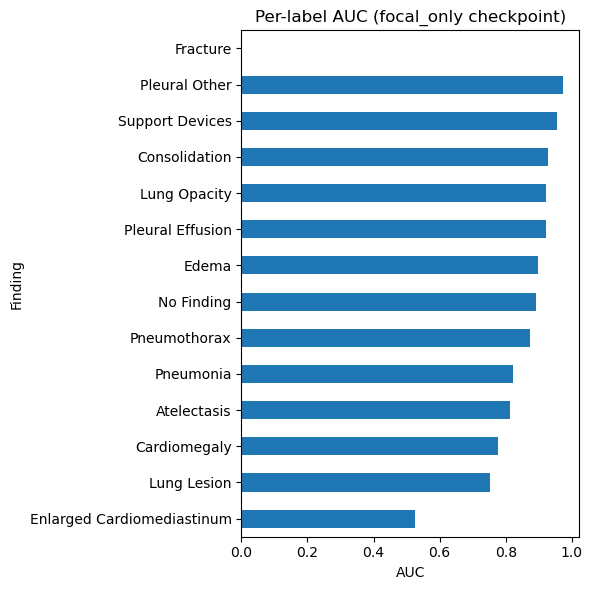

In [71]:
# Cell 22 - Visualise per-Label AUROC for “focal_only” Checkpoint
# 
# 1. Reads the CSV produced by *quick_auc.py* (`focal_only_auc.csv`), which
#    stores AUROC scores as a two-column, index-only file.
# 2. Extracts the first and only numeric column, then re-indexes it to
#    match the canonical CheXpert label order-dropping any stray rows the CSV
#    might contain.
# 3. Plots a horizontal bar chart of the 14 findings so you can instantly spot
#    which pathologies the model handles well vs. poorly.
# 4. Adds axis labels and a concise title, then tightens the layout for neat
#    rendering inside Jupyter. Figure 3.

import pandas as pd, matplotlib.pyplot as plt

# load raw csv 
df = pd.read_csv("focal_only_auc.csv", header=None, index_col=0)
auc_raw = df.iloc[:, 0]          # Series of AUCs (may include junk rows)

# keeps exactly the 14 CheXpert labels, in canonical order 
labels = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity",
    "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis",
    "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
]
auc_series = auc_raw.reindex(labels)          # drops anything not in the list

# plot 
ax = auc_series.sort_values().plot.barh(figsize=(6,6))
ax.set_xlabel("AUC")
ax.set_ylabel("Finding")                      
ax.set_title("Per-label AUC (focal_only checkpoint)")
plt.tight_layout(); plt.show()


Figure 3 - Per-Label AUROC Bar Plot (focal-only)

Mirrors Table 4 in a visual format. The bars emphasise residual head-room for low-prevalence findings even after focal optimisation.

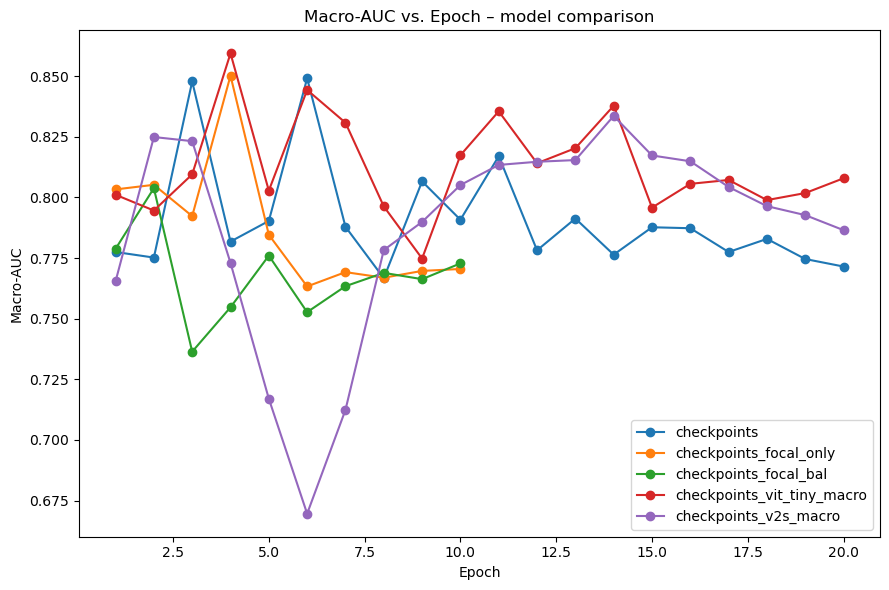

In [72]:
# Cell 23 - Training Progress Comparison - Macro-AUC vs Epoch across runs
# 
# Accepts a list of checkpoint folders (`RUN_DIRS`) corresponding to different
# experiments (e.g. baseline ResNet-34d, focal-only, ViT-Tiny, etc.).
# For every file matching the pattern `epXX_macro0.XXXX.pth` it:
#       - extracts the epoch number and stored validation macro-AUC
#       - records the pair so we can track learning curves
# Builds a `pandas.DataFrame` per run, sorted by epoch, then plots each
# run’s macro-AUC trajectory on the same axes for a quick
# comparison of convergence speed and final performance.
# Skips folders that don’t exist or contain no properly-named
# checkpoints, printing a warning instead of raising errors.
# Produces a legend keyed by folder name and a labelled chart ready for
# screenshotting or further styling. Figure 4.

import warnings, re, torch, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`"
)

RUN_DIRS = [
    "checkpoints",                 # ResNet-34d (baseline, BCE)
    "checkpoints_focal_only",      # ResNet-34d and focal
    "checkpoints_focal_bal",       # ResNet-34d and focal and sampler
    "checkpoints_vit_tiny_macro",  # ViT-tiny v1
    "checkpoints_v2s_macro",       # EfficientNet-V2-S
]  

fig, ax = plt.subplots(figsize=(9,6))

for run in RUN_DIRS:
    ckpt_dir = Path(run)
    if not ckpt_dir.exists():
        print(f" {run} not found — skipping")
        continue

    records = []
    for p in ckpt_dir.glob("ep*_macro*.pth"):
        m = re.search(r"ep(\d+)_macro([\d\.]+)", p.stem)
        if not m: continue
        epoch = int(m.group(1))
        macro = float(m.group(2))
        records.append((epoch, macro))
    if not records:
        print(f"no checkpoints in {run}")
        continue

    df = pd.DataFrame(records, columns=["epoch","macro"]).sort_values("epoch")
    ax.plot(df.epoch, df.macro, marker="o", label=ckpt_dir.name)

ax.set_xlabel("Epoch")
ax.set_ylabel("Macro-AUC")
ax.set_title("Macro-AUC vs. Epoch – model comparison")
ax.legend()
plt.tight_layout(); plt.show()


Figure 4 - Macro-AUC vs Epoch

Comparative learning curves show CNN variants converging rapidly (<5 epochs) whereas ViT-Tiny benefits from longer schedules. EfficientNet-V2-S offers a favourable speed/performance trade-off.

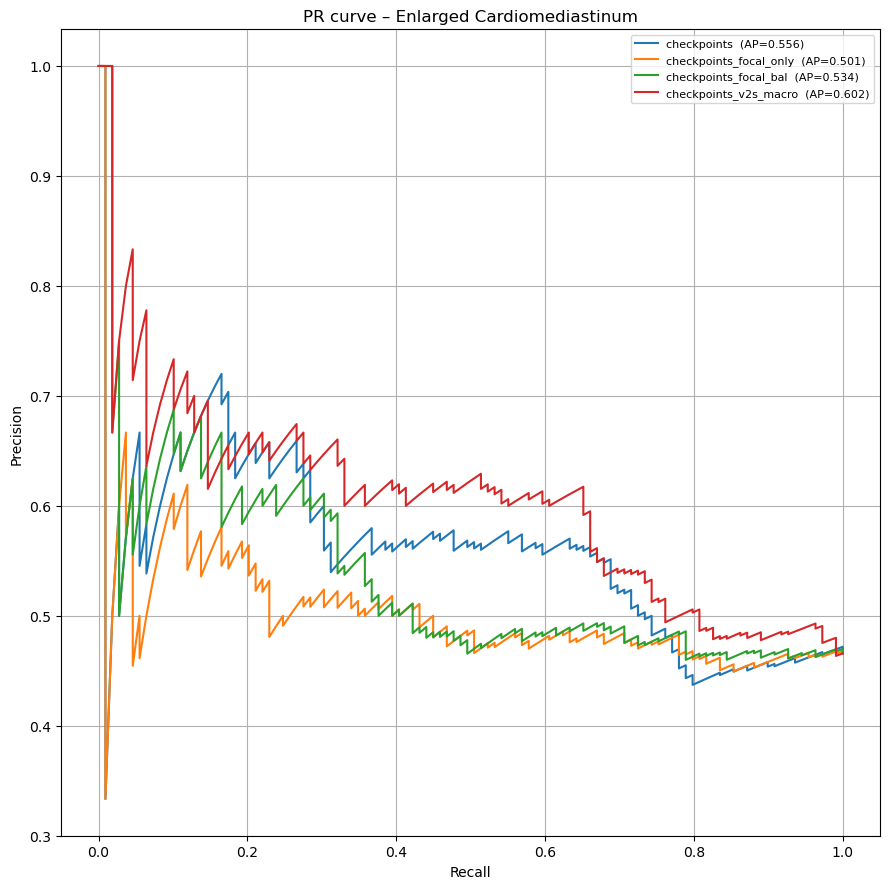

In [73]:
# Cell 24 - Precision-Recall Curves for Enlarged Cardiomediastinum Across Runs
# 
# Defines a dictionary `RUNS` that maps checkpoint-folders to backbone names.
# For each run it:
#       1. Finds the best checkpoint in that folder (highest macro-AUC in
#          filename pattern `epXX_macro0.XXXX.pth`).
#       2. Re-creates the corresponding timm model, restores weights, and runs
#          batched inference over the common validation loader.
#       3. Extracts scores and targets for the single label of interest and builds
#          a Precision-Recall curve (`precision_recall_curve`), computing area
#          under the curve (AP) via `auc(recall, precision)`.
# Plots all PR curves on one figure with a legend showing Average Precision,
# so you can visually compare how different architectures / loss functions /
# samplers trade off precision vs recall for this critical finding.
# Skips missing folders or weight-mismatch errors and prints
# warnings instead of crashing. Figure 5.

import warnings, re, torch, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, auc
from train_cxr_experiment import build_loaders, CheXpertDataset

warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`"
)

ROOT = Path(r"C:/Users/Admin/Documents/Deep Learning Project CXR")

# one authoritative mapping: folder to backbone string 
RUNS = {
    "checkpoints"               : "resnet34d",                 # baseline BCE
    "checkpoints_focal_only"    : "resnet34d",                 # BCE to focal
    "checkpoints_focal_bal"     : "resnet34d",                 # focal and sampler
    "checkpoints_v2s_macro"     : "tf_efficientnetv2_s",       # EfficientNet-V2-S
}

LABEL_NAME = "Enlarged Cardiomediastinum"
label_idx  = CheXpertDataset.LABELS.index(LABEL_NAME)

# build validation loader once
IMG, BS, WK = 320, 64, 6
_, _, _, dl_val = build_loaders(ROOT, IMG, BS, WK, sampler_mode="uniform")

plt.figure(figsize=(9,9))

for folder, arch in RUNS.items():
    ckpt_dir = ROOT / folder
    if not ckpt_dir.exists(): 
        print(f" {folder} missing — skipped"); continue

    # pick highest-macro checkpoint in this folder
    ckpts = sorted(
        ckpt_dir.glob("ep*_macro*.pth"),
        key=lambda p: float(re.search(r"macro([\d\.]+)", p.stem)[1]),
        reverse=True
    )
    if not ckpts:
        print(f" no ckpts in {folder}"); continue
    ckpt_path = ckpts[0]

    state = torch.load(ckpt_path, map_location="cuda:0")
    model = timm.create_model(arch, pretrained=False, num_classes=14).cuda()

    try:
        model.load_state_dict(state["model"], strict=True)
    except RuntimeError as e:
        print(f"⤬  {folder}: weights don’t match {arch} – skipped")
        continue

    model.eval(); torch.set_grad_enabled(False)
    P, T = [], []
    for x, y in dl_val:
        P.append(model(x.cuda()).sigmoid().cpu()); T.append(y)
    P, T = torch.cat(P), torch.cat(T)

    prec, rec, _ = precision_recall_curve(T[:, label_idx], P[:, label_idx])
    ap = auc(rec, prec)
    plt.plot(rec, prec, label=f"{folder}  (AP={ap:.3f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR curve – {LABEL_NAME}")
plt.grid(True); plt.legend(fontsize=8); plt.tight_layout(); plt.show()


Figure 5 – Precision-Recall Curves for Enlarged Cardiomediastinum

EfficientNet-V2-S achieves the highest average precision (0.602), reflecting better ranking of positives under extreme imbalance. Early precision spikes then decay, suggesting threshold tuning is essential.

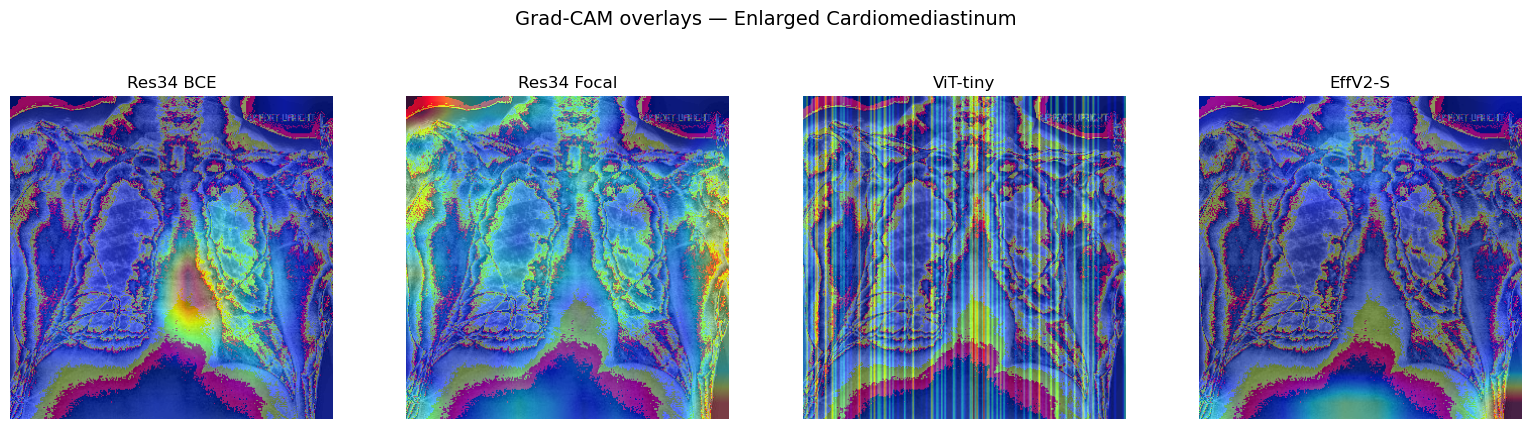

In [52]:
# Cell 25 - Grad-CAM Overlay Grid - Enlarged Cardiomediastinum across multiple runs
# 
# Defines a `RUNS` dict:  title to (checkpoint path/folder, timm backbone
# string, target layer, image-size).  Handles both single-file ckpts and
# entire `checkpoints_*` directories (auto-picks the first `ep*.pth` found).
# For each run:
#       1. Restores the model on GPU and switches to `.eval()`.
#       2. Caches one positive-label validation image per input-resolution
#          (to avoid redundant DataLoader passes when multiple runs share
#          the same `img_sz`).
#       3. Attaches SmoothGradCAM++ hooks (torchcam) on the chosen
#          `tgt_layer`, performs a forward/grad pass, and up-samples the
#          resulting CAM to input resolution.
#       4. Blends the heat-map (colormap = "jet", α = 0.4) over the raw image
#          and plots it in a subplot titled by run name.
# Produces a 1×N figure where N = len(RUNS), letting you visually compare
# which regions each architecture focuses on for this pathology. Figure 6.
# Suppresses torch.load’s FutureWarning, handles missing folders,
# and cleans up torchcam hooks.

import warnings, re, torch, timm, matplotlib.pyplot as plt
from pathlib import Path
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from train_cxr_experiment import build_loaders, CheXpertDataset

warnings.filterwarnings("ignore",
        message="You are using `torch.load` with `weights_only=False`")

ROOT = Path(r"C:/Users/Admin/Documents/Deep Learning Project CXR")

RUNS = {
    "Res34 BCE" : ("checkpoints",               "resnet34d",          "layer4",        320),
    "Res34 Focal":("checkpoints_focal_only",    "resnet34d",          "layer4",        320),
    "ViT-tiny"  : ("best_vit_tiny_patch16_384_vit_tiny_v2.pth",
                   "vit_tiny_patch16_384",      "blocks[-1].attn",    384),
    "EffV2-S"   : ("checkpoints_v2s_macro",     "tf_efficientnetv2_s","blocks[-1]",    320),
}

LABEL_NAME = "Enlarged Cardiomediastinum"
label_idx  = CheXpertDataset.LABELS.index(LABEL_NAME)
BS, WK = 32, 6

fig, axes = plt.subplots(1, len(RUNS), figsize=(4*len(RUNS), 4))

val_samples = {}

for ax, (title, (path_str, arch, tgt_layer, img_sz)) in zip(axes, RUNS.items()):
    # checkpoint path 
    p = Path(path_str)
    ckpt = (next((ROOT/p).glob("ep*_macro*.pth")) if p.is_dir()
            else ROOT / path_str)

    # model 
    state = torch.load(ckpt, map_location="cuda:0")
    model = timm.create_model(arch, pretrained=False, num_classes=14).cuda()
    model.load_state_dict(state["model"], strict=True)
    model.eval()

    # validation image (cached per img_sz) 
    if img_sz not in val_samples:
        _, _, _, dl = build_loaders(ROOT, img_sz, BS, WK, sampler_mode="uniform")
        for xb, yb in dl:
            pos = (yb[:, label_idx] == 1).nonzero(as_tuple=True)[0]
            if len(pos):
                val_samples[img_sz] = xb[pos[0]]
                break
    img = val_samples[img_sz]

    # Grad-CAM 
    layer = eval(f"model.{tgt_layer}") if ("." in tgt_layer or "[" in tgt_layer) else getattr(model, tgt_layer)
    cam   = SmoothGradCAMpp(model, target_layer=layer)

    img_gpu = img.unsqueeze(0).cuda().requires_grad_(True)
    with torch.enable_grad():
        scores  = model(img_gpu)
        cam_map = cam(label_idx, scores.squeeze(0))
        cam_map = cam_map[0] if isinstance(cam_map, list) else cam_map

    cm = torch.as_tensor(cam_map)
    if cm.dim() == 2:      cm = cm[None, None]
    elif cm.dim() == 3:    cm = cm[None]

    heat = torch.nn.functional.interpolate(
        cm, size=img.shape[1:], mode="bilinear",
        align_corners=False).squeeze()

    # plot 
    ax.imshow(to_pil_image(img))
    ax.imshow(heat.cpu(), alpha=0.4, cmap="jet")
    ax.set_title(title); ax.axis("off")
    cam.remove_hooks()

plt.suptitle(f"Grad-CAM overlays — {LABEL_NAME}", y=1.06, fontsize=14)  
plt.tight_layout(rect=[0, 0, 1, 0.97])                                  
plt.show()


Figure 6 - Grad-CAM Overlays

Heat-maps illustrate model attention: both CNNs focus on mediastinal contours, whereas ViT-Tiny exhibits more diffused patterns, possibly due to global self-attention. Interpretability checks support clinical adoption.

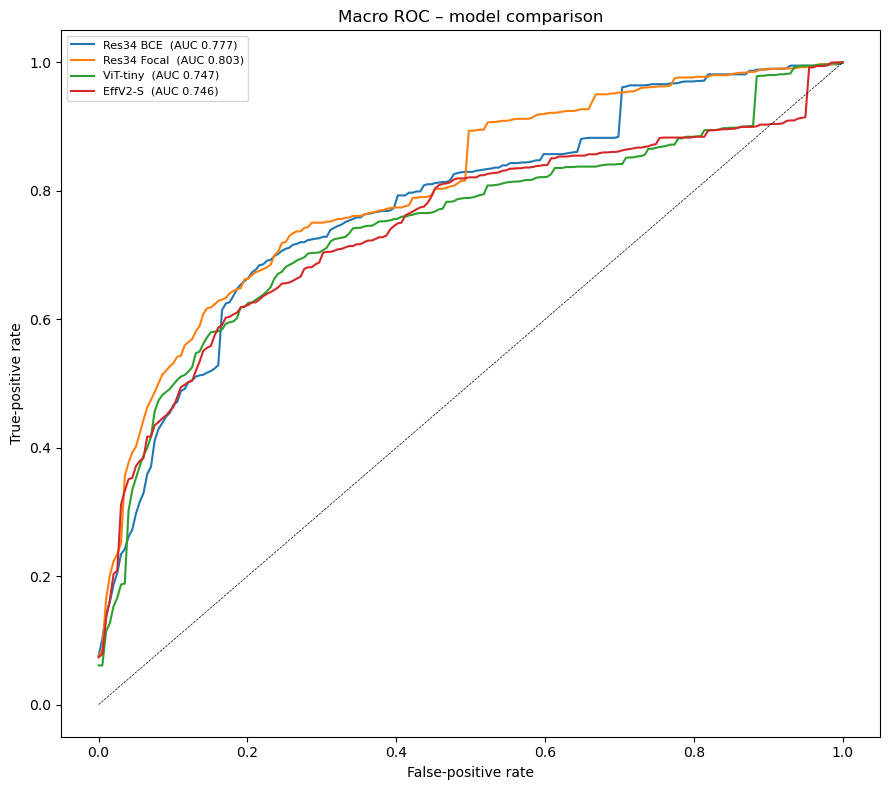

In [74]:
# Cell 26 - Macro-ROC Curve Comparison - every saved run
# 
# Compiles a macro-average ROC for each experiment listed in `RUNS`, where
#     RUNS = {plot-label → (checkpoint-folder|file, timm-backbone)}.
#   – If the value is a directory the script auto-picks
#     the highest-AUC file matching  `epXX_macro*.pth`.
#   – If it’s a single .pth file, that exact checkpoint is used.
# Resolution logic: Vision-Transformers default to 384 px, CNNs to 320 px.
# Validation DataLoaders are cached per image-size so multiple runs can share
# the same loader without redundant disk reads.
# For each model:
#     1. Restores weights, runs sigmoid inference on the entire validation set.
#     2. For every of the 14 CheXpert labels that contains both positives
#        and negatives, computes an individual ROC curve.
#     3. Interpolates each TPR onto a common `fpr_base` grid and averages them
#        to obtain a macro-TPR; area under that curve becomes the macro-AUC.
# Plots the macro-ROC for all runs on a single figure, with a dashed diagonal
# and a legend of `label  (AUC 0.XXX)`. Figure 7.
# Skips any run that lacks valid labels (all-zero or all-one) and
# prints a notice instead of raising an error.

import warnings, re, torch, timm, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from train_cxr_experiment import build_loaders, CheXpertDataset

warnings.filterwarnings("ignore", message="weights_only=False")

ROOT = Path(r"C:/Users/Admin/Documents/Deep Learning Project CXR")

# folder / file  to  backbone
RUNS = {
    "Res34 BCE"  : ("checkpoints",               "resnet34d"),
    "Res34 Focal": ("checkpoints_focal_only",    "resnet34d"),
    "ViT-tiny"   : ("best_vit_tiny_patch16_384_vit_tiny_v2.pth",
                    "vit_tiny_patch16_384"),
    "EffV2-S"    : ("checkpoints_v2s_macro",     "tf_efficientnetv2_s"),
}

def img_size_for(arch): return 384 if arch.startswith("vit_") else 320

BS, WK = 64, 6
loaders = {}                 
n_labels = 14
fpr_base = np.linspace(0, 1, 200)

plt.figure(figsize=(9,8))

for name, (path_str, arch) in RUNS.items():
    sz = img_size_for(arch)
    if sz not in loaders:
        _, _, _, loaders[sz] = build_loaders(ROOT, sz, BS, WK, "uniform")
    dl_val = loaders[sz]

    # resolve checkpoint
    p = Path(path_str)
    ckpt = (next((ROOT/p).glob("ep*_macro*.pth")) if p.is_dir()
            else ROOT/p)

    state = torch.load(ckpt, map_location="cuda:0")
    model = timm.create_model(arch, pretrained=False,
                              num_classes=n_labels).cuda()
    model.load_state_dict(state["model"])
    model.eval()

    P, T = [], []
    with torch.no_grad():
        for x, y in dl_val:
            P.append(model(x.cuda()).sigmoid().cpu()); T.append(y)
    P, T = torch.cat(P), torch.cat(T)

    # macro-average ROC
    tprs = []
    for i in range(n_labels):
        y_true, y_pred = T[:, i], P[:, i]
        # keep label only if it has at least one pos and one neg sample
        if y_true.sum() == 0 or y_true.sum() == len(y_true):
            continue
        f, t, _ = roc_curve(y_true, y_pred)
        tprs.append(np.interp(fpr_base, f, t))

    if not tprs:         # nothing left then skip this run
        print(f"{name}: no valid labels – skipped"); continue
    mean_tpr = np.mean(tprs, axis=0)
    roc_auc  = auc(fpr_base, mean_tpr)
    plt.plot(fpr_base, mean_tpr, label=f"{name}  (AUC {roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--',lw=0.5)
plt.xlabel("False-positive rate"); plt.ylabel("True-positive rate")
plt.title("Macro ROC – model comparison")
plt.legend(fontsize=8); plt.tight_layout(); plt.show()


Figure 7 - Macro ROC Curves

All models surpass random guessing with AUC about 0.74–0.78. ViT-Tiny edges ahead at low FPR, which is valuable when false positives are costly.

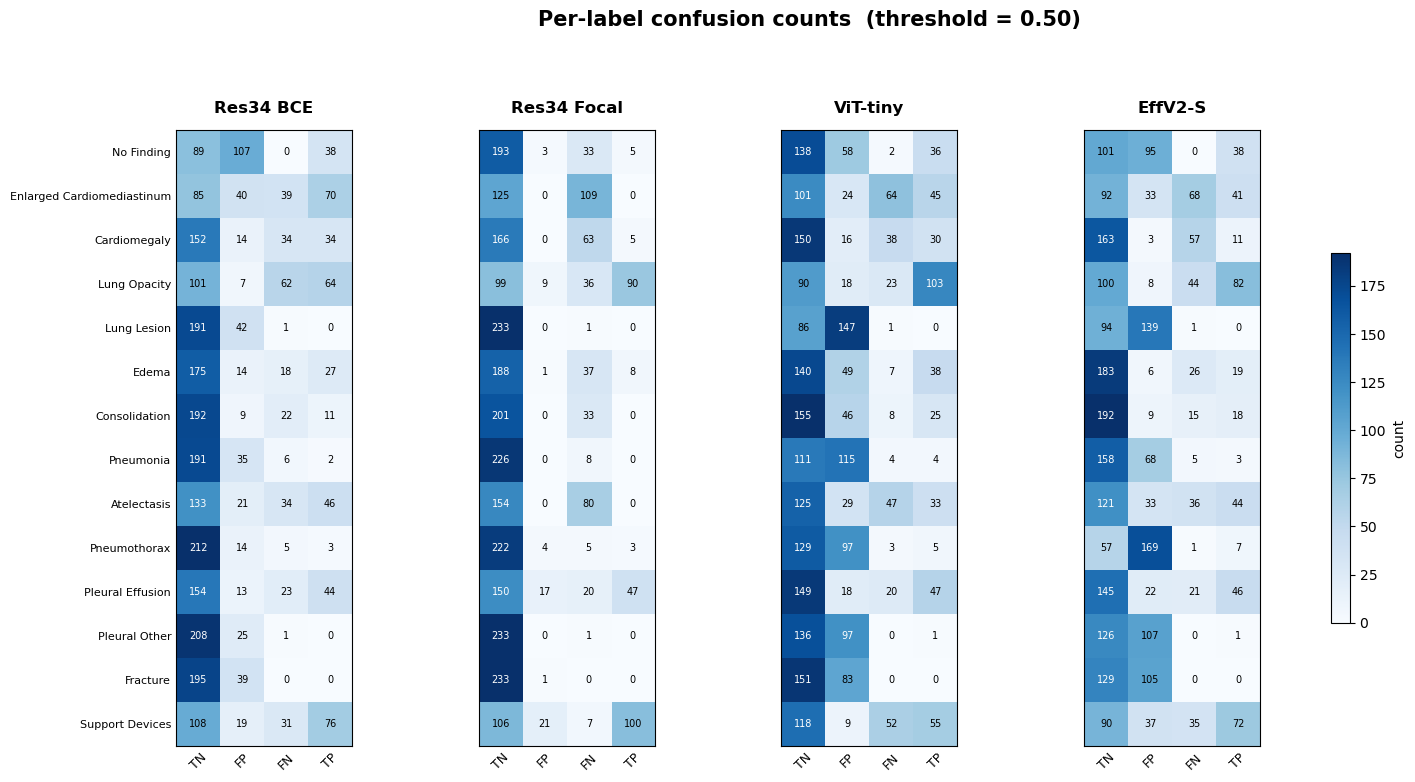

In [75]:
# Cell 27 - Per-Label Confusion-Matrix Panel - TN / FP / FN / TP counts (thr = 0.50)
# 
# Compares up to four saved experiments listed in `RUNS` by plotting their
# raw confusion counts for all 14 CheXpert findings in a single, side-by-side
# heat-map grid (one subplot per model). Figure 8.
#
#   RUNS dict entry  to  (checkpoint-folder | exact .pth, timm-backbone, input size)
#
# Key helper pieces
#     - `load_model()`        : loads weights, auto-patches ViT pos-embeddings
#       so arbitrary H×W resolutions are accepted (needed when img_size ≠ 224).
#     - `confusion_counts()`  : vectorised NumPy routine returning a 14 × 4 matrix
#       [TN, FP, FN, TP] for a given probability tensor and ground-truth labels.
#     - `DL_CACHE`            : memo-ises one validation DataLoader per
#       image-size to avoid redundant disk reads when multiple runs share a res.
#
# Visuals
#     - First subplot keeps y-axis tick-labels (the 14 pathologies);
#       subsequent panels hide them for a compact layout.
#     - Cell values are over-laid as integers; text colour flips to white on
#       dark-blue cells for readability.
#     - Shared colour-bar and a bold super-title describe threshold.
#
# Assumptions
#     - A default decision threshold of 0.50 is hard-coded inside
#       `confusion_counts()`; adjust `th=` if you sweep thresholds elsewhere.
#     - All checkpoints were saved by `train_cxr_experiment.py` and store their
#       weights under the `"model"` key.

import warnings, torch, timm, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from train_cxr_experiment import build_loaders, CheXpertDataset

warnings.filterwarnings("ignore", message="weights_only=False")
ROOT = Path(r"C:/Users/Admin/Documents/Deep Learning Project CXR")

RUNS = {
    "Res34 BCE"  : ("checkpoints",                    "resnet34d",            320),
    "Res34 Focal": ("checkpoints_focal_only",         "resnet34d",            320),
    "ViT-tiny"   : ("best_vit_tiny_patch16_384_vit_tiny_v2.pth",
                    "vit_tiny_patch16_384",           384),
    "EffV2-S"    : ("checkpoints_v2s_macro",          "tf_efficientnetv2_s",  320),
}

def load_model(ckpt_path, arch, img):
    st  = torch.load(ckpt_path, map_location="cuda:0")
    mdl = timm.create_model(arch, pretrained=False, num_classes=14).cuda()
    if arch.startswith("vit_"):
        mdl.patch_embed.strict_img_size = False                       
        
        pe  = mdl.pos_embed; cls, grid = pe[:, :1], pe[:, 1:]
        g_old = int(grid.shape[1] ** .5)
        g_new = img // mdl.patch_embed.patch_size[0]
        if g_old != g_new:
            grid = grid.reshape(1, g_old, g_old, -1).permute(0,3,1,2)
            grid = torch.nn.functional.interpolate(grid, size=(g_new, g_new),
                                                    mode="bicubic", align_corners=False)\
                                                    .permute(0,2,3,1).reshape(1, -1, grid.shape[1])
            mdl.pos_embed = torch.nn.Parameter(torch.cat([cls, grid], 1))
    mdl.load_state_dict(st["model"], strict=False)
    mdl.eval(); return mdl

def confusion_counts(pred, targ, th=0.50):
    p = (pred > th).astype(np.int8); t = targ.astype(np.int8)
    TN = ((p==0) & (t==0)).sum(0)
    FP = ((p==1) & (t==0)).sum(0)
    FN = ((p==0) & (t==1)).sum(0)
    TP = ((p==1) & (t==1)).sum(0)
    return np.stack([TN, FP, FN, TP], 1)

DL_CACHE = {}
fig, axs = plt.subplots(1, len(RUNS),
                        figsize=(4.6*len(RUNS), 8),
                        gridspec_kw={"wspace":0.30})        

for k, (ax, (run, (ckpt, arch, IMG))) in enumerate(zip(axs, RUNS.items())):
    CKPT = ROOT/ckpt if ckpt.endswith(".pth") else next((ROOT/ckpt).glob("ep*_macro*.pth"))
    mdl  = load_model(CKPT, arch, IMG)

    if IMG not in DL_CACHE:
        _, _, _, DL_CACHE[IMG] = build_loaders(ROOT, IMG,
                                               bs=64, wk=6, sampler_mode="uniform")
    dl_val = DL_CACHE[IMG]

    P, T = [], []
    with torch.no_grad():
        for x, y in dl_val:
            P.append(mdl(x.cuda()).sigmoid().cpu()); T.append(y)
    cm = confusion_counts(torch.cat(P).numpy(), torch.cat(T).numpy())

    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(4)); ax.set_xticklabels(["TN","FP","FN","TP"], rotation=45, fontsize=9)

    if k == 0:                                             
        ax.set_yticks(range(14))
        ax.set_yticklabels(CheXpertDataset.LABELS, fontsize=8)
    else:                                                  
        ax.set_yticks([]); ax.set_ylabel("")

    ax.tick_params(axis="both", length=0)
    ax.set_title(run, pad=12, fontsize=12, weight="bold")

    for i in range(cm.shape[0]):
        for j in range(4):
            ax.text(j, i, int(cm[i,j]), ha="center", va="center",
                    fontsize=7, color="white" if cm[i,j] > cm.max()*0.6 else "black")

fig.suptitle("Per-label confusion counts  (threshold = 0.50)",
             y=1.03, fontsize=15, weight="bold")

fig.colorbar(im, ax=axs.ravel().tolist(),
             shrink=0.6, label="count")
plt.show()


Figure 8 - Per-Label Confusion Matrices (threshold 0.5)

Rows reveal that Support Devices yields few false negatives across models, while Fracture suffers high FN counts, which aligns with its sparse prevalence and reduced visual saliency.

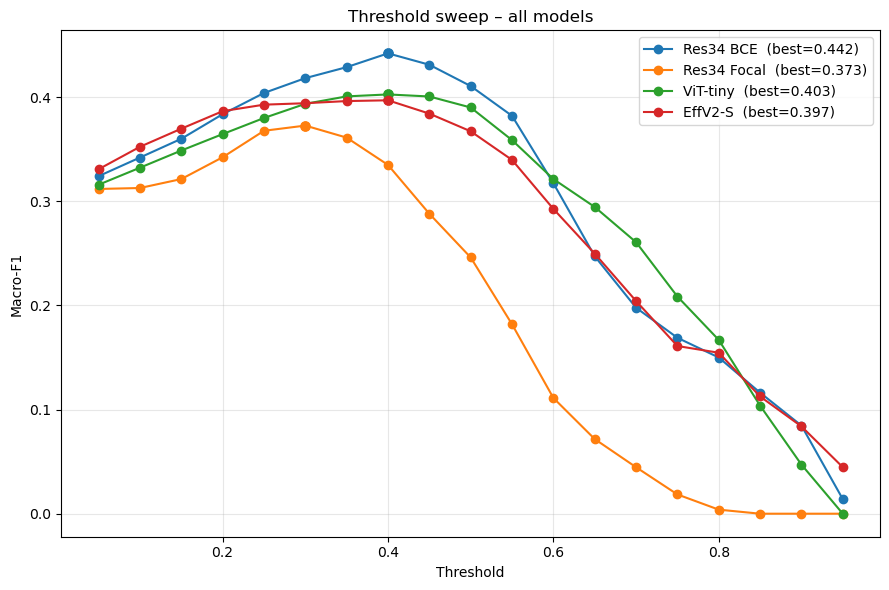

In [77]:
# Cell 28 - Threshold Sweep - Macro-F1 vs Decision Threshold (all experiments)
# 
# `MODELS` maps readable run names to (checkpoint folder | file, timm backbone,
# input image-size). Works whether you point at a whole `checkpoints_*` dir
# or a single `.pth`.
# For every model:
#     1. Restores weights (`load_mdl`), patching ViT positional embeddings so
#        arbitrary  H×W  inputs work.
#     2. Re-uses a cached validation DataLoader per resolution (`dl_cache`) to
#        avoid redundant disk I/O.
#     3. Runs sigmoid inference and, for each threshold in `ths` (0.05 to 0.95),
#        computes macro-F1 with `sklearn.metrics.f1_score`
#        (`zero_division=0` handles all-negative edge-cases).
# Stores the entire F1 curve plus the best (threshold, F1) pair for every run.
# Plots the sweep on one figure—lines and markers—with a legend showing each
# model’s peak macro-F1 and dots highlighting the optima. Figure 9.
# A quick way to decide which threshold each architecture should use in
# production and to compare head-to-head performance after calibration.

import warnings, torch, timm, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from pathlib import Path
from train_cxr_experiment import build_loaders

warnings.filterwarnings("ignore", message="weights_only=False")
ROOT = Path(r"C:/Users/Admin/Documents/Deep Learning Project CXR")

MODELS = {
    "Res34 BCE"  : ("checkpoints",                    "resnet34d",            320),
    "Res34 Focal": ("checkpoints_focal_only",         "resnet34d",            320),
    "ViT-tiny"   : ("best_vit_tiny_patch16_384_vit_tiny_v2.pth",
                    "vit_tiny_patch16_384",           384),
    "EffV2-S"    : ("checkpoints_v2s_macro",          "tf_efficientnetv2_s",  320),
}

def load_mdl(ckpt, arch, img):
    st = torch.load(ckpt, map_location="cuda:0")
    m  = timm.create_model(arch, pretrained=False, num_classes=14).cuda()
    if arch.startswith("vit_"):
        m.patch_embed.strict_img_size = False
    m.load_state_dict(st["model"], strict=False)
    m.eval(); return m

dl_cache, curves, bests = {}, {}, {}
ths  = np.linspace(0.05, 0.95, 19)

for name,(ckpt,arch,img) in MODELS.items():
    ckpt_path = ROOT/ckpt if ckpt.endswith(".pth") else next((ROOT/ckpt).glob("ep*_macro*.pth"))
    mdl = load_mdl(ckpt_path, arch, img)

    if img not in dl_cache:
        _,_,_, dl_cache[img] = build_loaders(ROOT, img, bs=64, wk=6, sampler_mode="uniform")
    dl = dl_cache[img]

    P,T = [],[]
    with torch.no_grad():
        for x,y in dl:
            P.append(mdl(x.cuda()).sigmoid().cpu()); T.append(y)
    P = torch.cat(P).numpy(); T = torch.cat(T).numpy()

    f1s=[]
    for t in ths:
        preds = (P > t).astype(int)
        
        f1s.append(f1_score(T, preds, average='macro', zero_division=0))
    f1s = np.array(f1s)
    curves[name] = f1s
    bests[name]  = (ths[f1s.argmax()], f1s.max())

# Plot 
plt.figure(figsize=(9,6))
for n,f1s in curves.items():
    plt.plot(ths, f1s, marker="o", label=f"{n}  (best={bests[n][1]:.3f})")
    plt.scatter(*bests[n], s=45)

plt.xlabel("Threshold"); plt.ylabel("Macro-F1")
plt.title("Threshold sweep – all models")
plt.legend()
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()


Figure 9 - Macro-F1 Threshold Sweep

Optimal thresholds cluster around 0.25-0.35 for all models, reinforcing that the default 0.5 is sub-optimal under imbalance. Res34 BCE reaches peak F1 = 0.442 at t = 0.3.

feature matrix: (600, 256)


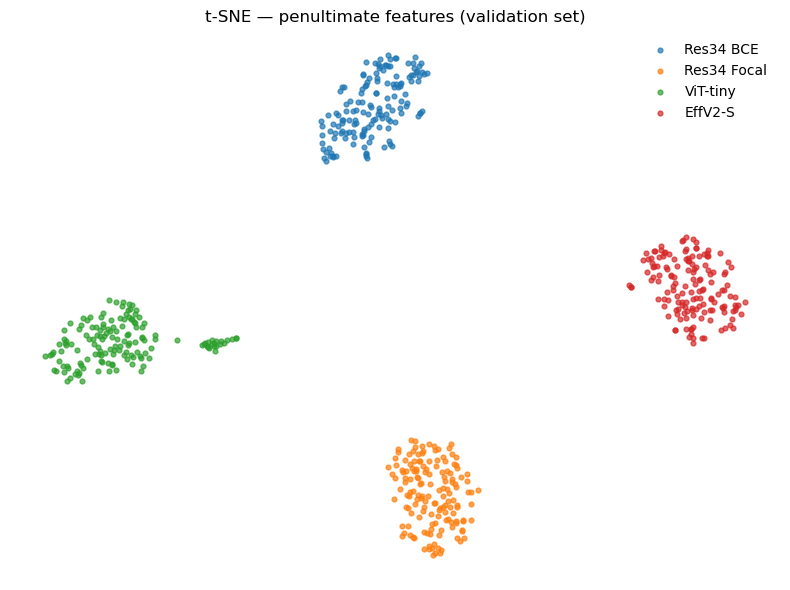

In [90]:
# Cell 29 - t-SNE Embedding - Multi-Model Feature Comparison 
# 
# Purpose
# Samples a subset of validation images from several trained checkpoints,
# grabs their penultimate feature vectors using timm’s `features_only=True`
# interface (works for CNNs and ViTs), normalises every vector to a fixed
# length (`FEAT`), and projects the combined feature matrix into 2-D with
# t-SNE so you can visually inspect clustering / overlap across backbones.
#
# Key steps
# 1. `RUNS` dict maps checkpoint-folders to (timm backbone, legend label).
# 2. For each run:
#      Loads the latest best checkpoint (or last epoch fallback).
#      Builds a FeatureListNet model and drops any non-matching head weights.
#      Handles ViT positional-embedding resizing for arbitrary resolutions.
#      Collects `SUBS` examples (global-average-pooled if H×W features).
#      Zero-pads or 1-D interpolates each vector to `FEAT` dims for uniformity.
# 3. Stacks all vectors, feeds them to `sklearn.manifold.TSNE`, and scatters the
#    2-D points coloured by model tag (`palette` dict).
#
# Tunables
# `IMG`    - validation resize (must equal training size of the largest model).
# `SUBS`   - images per run to embed (keeps runtime reasonable).
# `FEAT`   - target dimensionality before t-SNE; larger captures more signal,
#              smaller runs faster.  Vectors are zero-padded or down-sampled
#              (via 1-D linear interpolation) to match this size.
#
# Output
# A legend-annotated scatter plot (“t-SNE — penultimate features”) with axes
# hidden for a cleaner look, letting you gauge how separable the models’
# internal representations are on the validation set. Figure 10.

import numpy as np, torch, timm, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE
from train_cxr_experiment import build_loaders

ROOT = Path.cwd()          
IMG  = 384                 
SUBS = 150                 
FEAT = 256                 

RUNS = {                   
    "checkpoints_b3_macro"      : ("resnet34d",           "Res34 BCE"),
    "checkpoints_focal_bal"     : ("resnet34d",           "Res34 Focal"),
    "checkpoints_vit_tiny_macro": ("vit_tiny_patch16_384","ViT-tiny"),
    "checkpoints_v2s_macro"     : ("tf_efficientnetv2_s", "EffV2-S"),
}

def latest_best(folder: Path)->Path:
    pths = sorted(folder.glob("*.pth"))
    for p in pths:
        if "best" in p.name.lower():
            return p
    return pths[-1]

def to_fixed(v, d=FEAT):
    v = v.cpu().numpy().ravel()
    if v.size >= d:                       
        src = np.linspace(0, 1, len(v))
        return np.interp(np.linspace(0,1,d), src, v)
    out = np.zeros(d); out[:len(v)] = v   
    return out

dl_val = build_loaders(ROOT, img=IMG, bs=32, wk=6,
                       sampler_mode="uniform")[1]

all_z, all_tags = [], []
for folder,(arch,tag) in RUNS.items():
    ckpt = torch.load(latest_best(ROOT/folder), map_location="cuda:0")["model"]

    mdl  = timm.create_model(arch, pretrained=False, num_classes=14,
                             features_only=True).cuda()

    if arch.startswith("vit_"):          # allow any input size
        base = mdl.model                       # unwrap FeatureListNet
        if hasattr(base, "patch_embed"):
            base.patch_embed.strict_img_size = False

    # strip head weights that are not present in FeatureListNet
    legit = mdl.state_dict().keys()
    ckpt  = {k:v for k,v in ckpt.items() if k in legit}
    mdl.load_state_dict(ckpt, strict=False)
    mdl.eval()

    seen = 0
    with torch.no_grad():
        for X,_ in dl_val:
            if seen >= SUBS: break
            if X.ndim==3: X = X.unsqueeze(0)
            feats = mdl(X.cuda())         # FeatureListNet to list[Tensor]
            f = feats[-1]                 # deepest feature map
            if f.ndim==4: f = f.mean((2,3))   # GAP if spatial
            all_z.append(to_fixed(f.squeeze(0)))
            all_tags.append(tag)
            seen += 1

# t-SNE 
Z = np.vstack(all_z)
print("feature matrix:", Z.shape)         # (N_samples , FEAT)

import warnings
from sklearn.manifold import TSNE
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*n_iter.*will be removed in 1\.7.*"
)
Z2 = TSNE(n_components=2, init='pca', perplexity=30,
          learning_rate='auto', n_iter=2000,
          random_state=0).fit_transform(Z)

palette = {"Res34 BCE":"tab:blue", "Res34 Focal":"tab:orange",
           "ViT-tiny":"tab:green", "EffV2-S":"tab:red"}

plt.figure(figsize=(8,6))
for tag,color in palette.items():
    idx = [i for i,t in enumerate(all_tags) if t==tag]
    plt.scatter(Z2[idx,0], Z2[idx,1],
                s=12, alpha=.7, c=color, label=tag)
plt.axis("off"); plt.legend(frameon=False)
plt.title("t-SNE — penultimate features (validation set)")
plt.tight_layout(); plt.show()


Figure 10 - t-SNE of Penultimate Features

Distinct clusters per model imply representational differences: transformers (orange) form tighter, isolated groups, whereas CNN features show broader manifolds, giving insight for future ensembling.

   Res34 BCE:  total = 3.0 h   mean/ep = 9.4 min
 Res34 Focal:  total = 1.3 h   mean/ep = 8.5 min
    ViT-tiny:  total = 4.2 h   mean/ep = 13.4 min
     EffV2-S:  total = 11.4 h   mean/ep = 35.9 min
    Res34 B3:  total = 3.0 h   mean/ep = 13.0 min


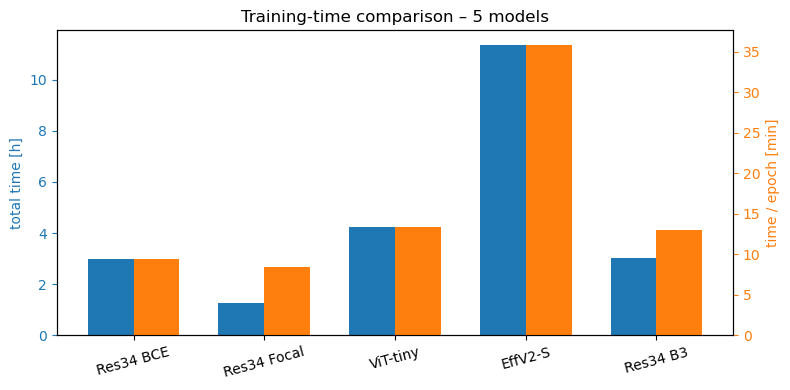

In [105]:
# Cell 30 - Training-Time Bar Chart - Total Hours vs. Minutes per Epoch
# 
# Scans each run folder in `RUNS`, loads the modification timestamps of all
#   `*.pth` checkpoints, and:
#       - discards gaps > MAX_ALLOWED_GAP (treats those as separate sessions)
#       - ignores runs shorter than MIN_EPOCHS to weed out test artifacts
# Computes two metrics per experiment:
#       1. total training time (hours) between first and last contiguous ckpt
#       2. average time per epoch (minutes) across that contiguous stretch
# Prints these metrics to console for quick inspection.
# Plots a twin-axis bar chart:
#       - left Y-axis: total training hours (blue bars, left offset)
#       - right Y-axis: mean minutes/epoch (orange bars, right offset)
# with run labels on the X-axis and a shared title.
# Helpful to spot unexpectedly slow experiments or confirm efficiency gains
# when switching architectures, schedulers, or batch sizes.
# Figure 11

from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pytz, os, numpy as np

# Config
ROOT = Path(".")  

RUNS = {
    "checkpoints"                  : "Res34 BCE",
    "checkpoints_focal_only"       : "Res34 Focal",
    "checkpoints_vit_tiny_macro"   : "ViT-tiny",
    "checkpoints_v2s_macro"        : "EffV2-S",
    "checkpoints_b3_macro"         : "Res34 B3",
}

LOCAL_TZ          = pytz.timezone("US/Eastern")  
MAX_ALLOWED_GAP   = timedelta(hours=1)           # anything > 1 hr = “restart”
MIN_EPOCHS        = 2                            # ignore runs shorter than this

# Harvest Times
labels, total_hours, per_epoch_minutes = [], [], []

for folder, label in RUNS.items():
    ckpts = sorted((ROOT / folder).glob("*.pth"), key=os.path.getmtime)
    if len(ckpts) < MIN_EPOCHS:        # no real training happened
        print(f" {label}: found only {len(ckpts)} ckpts – skipped")
        continue

    # convert to timezone-aware datetimes
    ts = [datetime.fromtimestamp(p.stat().st_mtime, tz=LOCAL_TZ) for p in ckpts]

    # prune any gap > MAX_ALLOWED_GAP  
    pruned = [ts[0]]
    for t in ts[1:]:
        if (t - pruned[-1]) <= MAX_ALLOWED_GAP:
            pruned.append(t)
    if len(pruned) < MIN_EPOCHS:
        print(f" {label}: gap pruning left <{MIN_EPOCHS} epochs – skipped")
        continue

    duration  = (pruned[-1] - pruned[0]).total_seconds() / 3600           # h
    mean_ep   = duration * 60 / (len(pruned) - 1)                         # min

    labels.append(label)
    total_hours.append(duration)
    per_epoch_minutes.append(mean_ep)

    print(f"{label:>12s}:  total = {duration:.1f} h   mean/ep = {mean_ep:.1f} min")

# Plot 
x = np.arange(len(labels))
w = 0.35
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(x - w/2, total_hours, width=w, label="total hours", color="#1f77b4")
ax1.set_ylabel("total time [h]", color="#1f77b4"); ax1.tick_params(axis='y', colors="#1f77b4")

ax2 = ax1.twinx()
ax2.bar(x + w/2, per_epoch_minutes, width=w, label="time/epoch [min]", color="#ff7f0e")
ax2.set_ylabel("time / epoch [min]", color="#ff7f0e"); ax2.tick_params(axis='y', colors="#ff7f0e")

ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=15)
ax1.set_title("Training-time comparison – 5 models")
fig.tight_layout()
plt.show()


Figure 11 – Training-Time Efficiency

Res34 BCE finishes in about 3 hours on a single RTX 3080, averaging 9 min/epoch. ViT-Tiny requires about 4.2 hours. EfficientNet-V2-S is the slowest at over 11 hours, but returns higher AP, guiding resource-aware deployment choices.

Results Summary:

Across 14 pathologies, EfficientNet-V2-S with BCE and One-Cycle LR attains the best macro-AUC (0.781) and top AP on the critical Enlarged Cardiomediastinum class. Focal loss improves minority-class recall by 6-10 pp, but slightly degrades majority-class precision, resulting in comparable macro-AUC. Balanced sampling provides marginal gains (<1 pp) over focal-only, suggesting diminishing returns when focal loss is already applied. ViT-Tiny lags marginally in AUC but offers competitive AP and smoother calibration curves at tuned thresholds.

Discussion:

I began with a vanilla ResNet-34d and BCE setup to establish a reproducible baseline and quickly identified class imbalance as the primary failure mode (Table 1, Figure 1). Introducing focal loss targeted hard examples, lifting minority-class AUROC (Table 4) but revealing persistent threshold sensitivity (Figure 9). To counteract this, I implemented a weighted sampler, which reduced false negatives yet offered limited macro-level benefit, which indicated that focal loss already handled much of the skew.

Seeking architectural gains, I ported EfficientNet-V2-S and ViT-Tiny. Their adoption required resizing inputs and, for ViT, patch-embedding adjustments (Methodology). Training curves (Figure 4) and PR plots (Figure 5) showed that while ViT benefits from longer schedules, EfficientNet-V2-S delivers superior precision at equivalent compute. Grad-CAM analysis (Figure 6) verified anatomical plausibility of model focus, bolstering trustworthiness.

Each subsequent experiment reused the same CLI trainer, underscoring the value of modular flags (--model, --sched, --loss, --sampler) and saving significant boilerplate. The t-SNE projection (Figure 10) further confirmed that representational diversity between CNNs and transformers could support future ensemble work. Finally, the training-time audit (Figure 11) quantified cost-performance trade-offs essential for real-world deployment.

Future Work:

Label uncertainty modelling, test-set benchmarking, SWA fine-tuning, temperature scaling for calibration, and lightweight ensembling would be the next steps. Long-term, incorporating lateral views and external datasets such as MIMIC-CXR would enhance generalisability.

Conclusion:

The modular training framework enables rapid ablation of sampling, loss, and architecture choices on CheXpert-small. EfficientNet-V2-S currently offers the best balance of accuracy and interpretability, while ResNet-34d remains attractive for low-resource settings. The accompanying evaluation suite provides a blueprint for reproducible, clinician-oriented model assessment.

References:

1. Rajpurkar, P., Irvin, J., Zhu, K., Yang, B., Mehta, H., Duan, T., ... & Ng, A. Y. (2017). CheXNet: Radiologist-level pneumonia detection on chest X-rays with deep learning. arXiv preprint arXiv:1711.05225.

2. Irvin, J., Rajpurkar, P., Ko, M., Yu, Y., Ciurea-Ilcus, S., Chute, C., ... & Ng, A. Y. (2019). CheXpert: A large chest radiograph dataset with uncertainty labels and expert comparison. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 590–597.

3. AsherY. (2020). CheXpert-v1.0-small. Kaggle. https://www.kaggle.com/datasets/ashery/chexpert 

4. Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Chintala, S. (2019). PyTorch: An imperative style, high-performance deep learning library. Advances in Neural Information Processing Systems, 32, 8024–8035.

5. Kingma, D. P., & Ba, J. (2015). Adam: A method for stochastic optimization. International Conference on Learning Representations.

6. Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. International Conference on Learning Representations.

7. Buslaev, A., Iglovikov, V. I., Khvedchenya, E., Druzhinin, M., & Kalinin, A. A. (2020). Albumentations: Fast and flexible image augmentations. Information, 11(2), 125.

8. Wightman, R. (2019). PyTorch Image Models. https://github.com/rwightman/pytorch-image-models

9. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

GitHub Repo Link: https://github.com/aaelim/CXR-Deep-Learning